In [3]:
#!conda install natsort -y

In [4]:
#!conda install gdal -y

In [4]:
#import required libraries
from numpy import loadtxt
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
from scipy.stats import skew
from scipy.optimize import least_squares
from scipy.io import savemat
from scipy import stats
import scipy.stats
import matplotlib.patches as patches
import util_mod
import datetime as dt
import pandas as pd
import natsort
import csv
from osgeo import gdal, osr, ogr

In [5]:
#These are a bunch of variables that we have to define for the cells below. We will change these parameters for each InSAR dataset that we use
sbas_list='sbas_list_reduced'#list of SBAS Interferogram pairs with scene names, temporal baseline, and spatial baseline
intlist='intlist_reduced'#list of interferograms corresponding to SBAS list
geolist='geolist_reduced'#list of scene names
nr0, nr =2214, 2214 #number of pixels in range
naz0, naz =3600, 3600 #number of pixels in azimuth
Bperp_file='Bperp_reduced.out' #matrix of (spatial) perpendicular baseline values
Tm_file='Tm_reduced.out' #matrix of temporal baseline values
deltime_file='deltime_reduced.out' #matrix of delta time values
timedeltas_file='timedeltas_reduced.out'
wvl=0.0554 #wavelength of radar (C band for Sentinel)
skew_val=0.4 #Skewness value for thresholding good and bad data

###highest average coherence through stack###
r_ref=[108, 154, 124, 101, 137]   #  reference pixel location
az_ref=[1111, 1271, 1117, 1319, 1244]  #  reference pixel location

In [6]:
#Step 1.
#1a. Read in all InSAR data (.unw unwrapped interferograms, .cc coherence files)
#1b. Read in ancillary files (list files, SBAS matrices)

print('Reading in InSAR data and SBAS Ancillary files')
f = open(sbas_list,'r')
sbas_pairs = []
for line in f:
    sbas_pairs.append(line.strip()) #.strip() function removes both the leading and the trailing characters
f.close()

f = open(intlist,'r')
int_pairs = []
for line in f:
    int_pairs.append(line.strip()) # reading in the data files so that the program can understand the data
f.close()                          #similar to when we truncated data previously 

f = open(geolist,'r')
geos = []
for line in f:
    geos.append(line.strip())
f.close()
N_geo = len(geos)
print('done')

Reading in InSAR data and SBAS Ancillary files
done


In [7]:
#Read in LOS vector
# Open the GeoTIFF file
with rasterio.open("warped_20210609_inc_map.tif") as src:
    # Read the data as a NumPy array
    los_rads = src.read()

In [8]:
#Visualize LOS array
#plt.imshow(np.squeeze(los_rads), cmap='viridis')
#plt.colorbar()
#plt.show()

In [9]:
#Read in Bperp info
lines = []
with open(Bperp_file, 'r') as fileobj:
    for row in fileobj:
        line = row.rstrip('\n')
        lines.append(float(line))
Bperp = np.asarray(lines)
N_int = Bperp.size

print('done')

done


In [10]:
#Read in time information
count1 = []
dtime_ints1 = []
time11 = []
time21 = []
with open(deltime_file, 'r') as fileobj:  #108 rows
    for row in fileobj:
        line = row.rstrip('\n')
        line_vals = line.split(' ')
        count1.append(float(line_vals[0]))
        dtime_ints1.append(float(line_vals[1]))
        time11.append(float(line_vals[2]))
        time21.append(float(line_vals[3]))
count = np.asarray(count1)
dtime_ints = np.asarray(dtime_ints1)
time1 = np.asarray(time11)
time2 = np.asarray(time21)
dtime_scenes_list = []
with open(timedeltas_file, 'r') as fileobj:  #113 rows
    for row in fileobj:
        line = row.rstrip('\n')
        dtime_scenes_list.append(float(line))
dtime_scenes = np.asarray(dtime_scenes_list)
N_scene = dtime_scenes.size+1
geo_dates = []
geo_doys = []
#geo_years=[] 
#geo_days=[]  
#geo_months=[]
for (i,geo) in enumerate(geos):
	d1 = geo[20:28]
	year1 = d1[0:4]
	month1 = d1[4:6]
	day1 = d1[6:8]
	doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
	geo_dates.append(str(day1))
	geo_doys.append(int(doy1))

In [14]:
#Read in Tm matrix as array N_int by N_scene
Tm1 = []
with open(Tm_file, 'r') as fileobj:
    for row in fileobj:
        line_vals = row.rstrip('\n')
        #line_vals=line.split(' ')
        #Tm1.append(line_vals[0:(N_scene-1)])
        Tm1.append(line_vals)
Tm0 = np.asarray(Tm1)
Tm2 = np.zeros((N_int,N_scene-1))
for i in range(N_int):
	line = Tm0[i]
	line_vals = line.split(' ')
	for j in range(N_scene-1):
		Tm2[i,j] = float(line_vals[j])
Tm = np.copy(Tm2)

In [15]:
#filtering .int files
good_scen2 = [1,2,3,4,10,11,12,13,14,15,16,17,18,19,20,28,30,32,33,
             34,35,36,37,38,42,57,59,60,61,62,66,67,69,75,79,80,81,
             82,83,84,85,86,87,88,89,90,91,92,93,94,98,100,102,103,
             105,106,108,109,110,112,115,125,126,127,129,130,132,133,
             134,135,136,137,138,139,140,141,142,145,148,150,151,153,
             154,157,160,162,163,164,165,166,167,168,169,170,171,172,
             175,181,184,190,193,195,196,197,198,199,200,201]
int_pairs = pd.DataFrame(int_pairs)

int_pairs.columns = ['.int date']

int_pairs = int_pairs['.int date']

int_pairs_filt = int_pairs.iloc[good_scen2]

int_pairs_filt = list(int_pairs_filt)

In [17]:
#Read in interferograms, unwrapped interferograms, coherence, and amplitude files
unw_phase = np.zeros((2100,1350,int(N_int)))
coh = np.zeros((2100,1350,int(N_int)))
date_pairs = []
doy_pairs = []

for (i,int_pair) in enumerate(int_pairs_filt):
    print(i)
    strunw1 = int_pair.replace('.int','.unw')
    stramp1 = int_pair.replace('.int','.amp')
    strcc1 = int_pair.replace('.int','.cc')
    strint1 = int_pair

    strunw = 'unws/'+str(strunw1)
    strint = 'ints/'+str(strint1)
    stramp = 'amps/'+str(stramp1)
    strcc = 'ccs/'+str(strcc1)

    (amp,unw_los) = util_mod.read_hgt_file(strunw,nr0)
    (amp,cor) = util_mod.read_hgt_file(strcc,nr0)

    #convert LOS unwrapped phase to vertical, assuming all deformation is vertical
    unw=np.divide(unw_los,np.cos(np.squeeze(los_rads)))
    
    unw_phase[:,:,i] = unw[500:2600,650:2000]
    coh[:,:,i] = cor[500:2600,650:2000]

    split1 = int_pair.split('_')
    d1 = split1[0]
    strint2 = split1[1]
    split2 = strint2.split('.')
    d2 = split2[0]

    year1 = d1[0:4]
    month1 = d1[4:6]
    day1 = d1[6:8]
    year2 = d2[0:4]
    month2 = d2[4:6]
    day2 = d2[6:8]

    doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
    doy2 = (dt.date(int(year2), int(month2), int(day2)) - dt.date(int(year2),1,1)).days + 1

    date_pair = [d1,d2]
    doy_pair = [doy1,doy2]
    print(doy_pair)
    print(date_pair)
    date_pairs.append(date_pair)
    doy_pairs.append(doy_pair)

print('Calculating Scenewide Average Coherence')

0
[331, 355]
['20161126', '20161220']
1
[355, 13]
['20161220', '20170113']
2
[13, 37]
['20170113', '20170206']
3
[37, 61]
['20170206', '20170302']
4
[73, 97]
['20170314', '20170407']
5
[85, 97]
['20170326', '20170407']
6
[73, 109]
['20170314', '20170419']
7
[85, 109]
['20170326', '20170419']
8
[97, 109]
['20170407', '20170419']
9
[85, 121]
['20170326', '20170501']
10
[97, 121]
['20170407', '20170501']
11
[109, 121]
['20170419', '20170501']
12
[97, 133]
['20170407', '20170513']
13
[109, 133]
['20170419', '20170513']
14
[121, 133]
['20170501', '20170513']
15
[217, 229]
['20170805', '20170817']
16
[229, 241]
['20170817', '20170829']
17
[229, 253]
['20170817', '20170910']
18
[241, 253]
['20170829', '20170910']
19
[229, 265]
['20170817', '20170922']
20
[241, 265]
['20170829', '20170922']
21
[253, 265]
['20170910', '20170922']
22
[253, 289]
['20170910', '20171016']
23
[265, 289]
['20170922', '20171016']
24
[301, 313]
['20171028', '20171109']
25
[361, 8]
['20171227', '20180108']
26
[361, 20]


In [18]:
avecc = np.mean(coh,axis=2)
cor_mask = np.copy(avecc)
cor_mask[cor_mask<0.425]=np.nan
cor_mask[cor_mask>0.425]=1
phase_cal = np.copy(unw_phase)

In [19]:
#using average value of coherence stack to find greatest values of coherence

#identifying greatest average values of coherence
avecc_sort = np.sort(avecc, axis=None)
list1 = [avecc_sort[-1],avecc_sort[-2],avecc_sort[-3],avecc_sort[-4],avecc_sort[-5]]

#identifying indices of greatest coherence values
for i in list1:
    print('The indices of highest coherence are:', 
          np.where(avecc == i)[0], np.where(avecc == i)[1], 
          'with an average coherence of', np.around(i, decimals = 7))
#input pixels for processing

The indices of highest coherence are: [108] [1111] with an average coherence of 0.9859841
The indices of highest coherence are: [154] [1271] with an average coherence of 0.972696
The indices of highest coherence are: [124] [1117] with an average coherence of 0.9709366
The indices of highest coherence are: [124] [1118] with an average coherence of 0.9688171
The indices of highest coherence are: [137] [1244] with an average coherence of 0.9639547


In [20]:
def sbas(dtime_scenes, array, Tm_good, naz_min, naz_max, nr_min, nr_max):
    '''
    Function to implement SBAS processing method according to
    specified subsets.
    '''    
    #reference pixel location
    r_ref=[108, 124, 124, 137, 154]  
    az_ref=[1111, 1117, 1118, 1244, 1271]
    
    #define range of subsetted image
    naz,nr = naz_max-naz_min, nr_max-nr_min
    print('Calibrating Phase with '+str(len(r_ref))+' reference pixels')
    print('Range coordinates of reference pixels are '+str(r_ref))
    print('Azimuth coordinates of reference pixels are '+str(az_ref))
    
    #incorporate reference points for processing
    pluck=array[az_ref,r_ref,:]
    pluck1=np.mean(pluck,axis=0)
    refphase=pluck1
    
    #inversion
    Tmi=np.linalg.pinv(Tm_good) 
    
    siz=Tmi.shape
    N_good=siz[0]
    velocities=np.zeros((naz,nr,N_good))

    print('Inverting for Instantaneous Phase Velocities')
    
    for i in range(naz_min,naz_max):
        for j in range(nr_min,nr_max):
            pluck = np.squeeze(array[i,j,:]) - np.squeeze(refphase)
            sol=np.matmul(Tmi,pluck)
            velocities[i-naz_min,j-nr_min,:] = sol
     
    phi_vec = np.zeros((naz,nr,len(geo_doys)))
    
    print('Integrating Phase Velocities into Time Series of Displacement')
    for i in range(naz):
        for j in range(nr):
            phi=np.zeros((N_scene,1))
            for k in range(2,N_geo):
                phi[k] = phi[k-1] + dtime_scenes[k-1]*velocities[i,j,k-1]
                
            phi_vec[i,j,:] = np.squeeze(phi)
    
    #converting radians to meters
    time_series132 = phi_vec *(-wvl/(4*np.pi)) 
    
    return time_series132

In [39]:
#Surface deformation analysis method
#function to calculate summer seasonal linear rates of change over smaller subsection
def subset_linear_rate_summer(year, good_scen2, dtime_scenes, intlist, array, naz_min, naz_max, nr_min, nr_max):
    '''
    Calculate the linear rate of change of surface 
    deformation according to specified year and summer season AND
    according to smaller subsets. 
    '''    
    #reference pixel location
    r_ref=[108, 124, 124, 137, 154]  
    az_ref=[1111, 1117, 1118, 1244, 1271]
    
    #size of interferogram
    naz, nr = 2100, 1350
    #size of smaller subset
    saz, sr = 3, 3
    
    #reference phase calculations
    pluck=array[az_ref,r_ref,:]
    pluck1=np.mean(pluck,axis=0)
    refphase=pluck1
    
    #calculate length of 3rd index based on year input 
    num = int_date.str.contains(year)
    new, new_idx = [], []
    for idx, x in enumerate(int_date):
         if num[idx] == True:
             #store array values
             new.append(x)
             #store idx values
             new_idx.append(idx)
                
    ##taking into account summer seasonal trends
    new_summer, summer_idx = [], []  
    var, var2 = [], []
    month, no_month = ['05','06','07','08','09'], ['10','11','12']
    var = ["".join([year,i]) for i in month]
    var2 = ["".join([year,i]) for i in no_month]

    ##isolating summer months
    for idx, x in enumerate(new): 
        for i in range(len(var)-1):
            if var[i] and var[i+1] in x:
                new_summer.append(x)
                summer_idx.append(idx)

    #remove remaining winter tailend months
    for idx, x in enumerate(new_summer):
        for i in range(len(var2)):
            if var2[i] in x:
                new_summer.pop(idx)
                summer_idx.pop(idx)
    res_sum = new_summer
    rates2=np.zeros((saz,sr,len(res_sum)))
    
    #Estimate the rate m/yr of change of the ground surface assuming a linear fit
    for idx, x in enumerate(summer_idx):
        pg2=array[naz_min:naz_max,nr_min:nr_max,idx]-np.squeeze(refphase[idx])
        rates2[:,:,idx]=np.divide(pg2,dtime_scenes[idx])
        
    rate2=np.mean(rates2,2) #3rd axis 
    #converting radians to meters, days into year
    rate2_seasonal=rate2*365*(-wvl/(4*np.pi)) 

    scenewide_avg=rate2_seasonal.mean(axis=(0,1))     
    
    return rate2_seasonal, scenewide_avg    

In [22]:
#converting list to numpy array
good_scen2 = np.array((good_scen2))
#for processing original vs refined dataset
r_ref=[10, 900, 1200, 139, 900]   #  reference pixel location
az_ref=[480, 1000, 1510, 30, 1250]  #  reference pixel location

In [23]:
intlist_date = pd.read_csv('intlist_36',  header=None)
int_date = intlist_date[0] #all 270 interferograms = int_date[good_scen2] #108 of original interferograms

In [24]:
#Northwest sbas applied
series_good_nw2 = sbas(dtime_scenes, phase_cal, Tm, 0, 1050, 0, 675)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [25]:
#Northeast sbas applied
series_good_ne2 = sbas(dtime_scenes, phase_cal, Tm, 0, 1050, 675, 1350)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [26]:
#Southeast sbas applied
series_good_se2 = sbas(dtime_scenes, phase_cal, Tm, 1050, 2100, 675, 1350)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [27]:
#Southwest sbas applied
series_good_sw2 = sbas(dtime_scenes, phase_cal, Tm, 1050, 2100, 0, 675)

Calibrating Phase with 5 reference pixels
Range coordinates of reference pixels are [108, 124, 124, 137, 154]
Azimuth coordinates of reference pixels are [1111, 1117, 1118, 1244, 1271]
Inverting for Instantaneous Phase Velocities
Integrating Phase Velocities into Time Series of Displacement


In [28]:
series_good_nw_ne2 = np.concatenate((series_good_nw2, series_good_ne2),axis=1)
series_good_sw_se2 = np.concatenate((series_good_sw2, series_good_se2),axis=1)
series_good_tot2 = np.concatenate((series_good_nw_ne2,series_good_sw_se2),axis=0)

In [61]:
#Save output matrices
#savemat('sbas_step1.mat', {'avecc': avecc,'cor_mask': cor_mask, 'Tm1': Tm2, 'Bperp1': Bperp,'dtime_scenes': dtime_scenes,'dtime_ints': dtime_ints,'geo_doys': geo_doys,'date_pairs': date_pairs,'doy_pairs': doy_pairs})
#savemat('sbas_step2.mat', {'time_series': series_good_tot2})

In [40]:
#3x3 subset
def subset_rates(year):
    pin_1 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,151,154,1160,1163)
    pin_2 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,309,312,791,794)
    pin_3 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,322,325,829,832)
    pin_4 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,330,333,673,676)
    pin_5 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,693,696,412,415)
    pin_6 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,726,729,830,833)
    pin_7 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,769,772,789,792)
    pin_8 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1580,1583,673,676)
    pin_9 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1782,1785,626,629)
    pin_10 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1820,1823,717,720)
    pin_11 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1961,1964,658,661)
    pin_12 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,2018,2021,570,573)
    pingo_list = [
        pin_1[1],  
        pin_2[1],  
        pin_3[1], 
        pin_4[1], 
        pin_5[1],
        pin_6[1], 
        pin_7[1],  
        pin_8[1], 
        pin_9[1], 
        pin_10[1],
        pin_11[1],
        pin_12[1]  
    ]
    return pingo_list

In [125]:
#10x10 subset
def subset_rates(year):
    #calculating dynamic subsets
    dyn_1 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,960,970,640,650) 
    dyn_2 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1500,1510,1000,1010)
    dyn_3 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1260,1270,1000,1010)
    #calculating constant subsets
    stab_1 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,510,520,900,910) 
    stab_2 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1710,1720,500,510)
    stab_3 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,865,875,1000,1010)
    #over pingos
    pin_1 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,147,157,1156,1166)
    pin_2 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,305,315,787,797)
    pin_3 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,318,328,825,835)
    pin_4 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,326,336,671,681)
    pin_5 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,689,699,408,418)
    pin_6 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,722,732,826,836)
    pin_7 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,765,775,785,795)
    pin_8 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1576,1586,669,679)
    pin_9 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1778,1788,622,632)
    pin_10 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1816,1826,713,723)
    pin_11 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,1957,1967,654,664)
    pin_12 = subset_linear_rate_summer(year, good_scen2, dtime_ints, intlist_date, series_good_tot2,2014,2024,566,576)
    pingo_list = [pin_1[1],pin_2[1],pin_3[1],pin_4[1],pin_5[1],pin_6[1],pin_7[1],pin_8[1],pin_9[1],pin_10[1],pin_11[1],pin_12[1]]
    tundra_list = [dyn_1[1],dyn_2[1],dyn_3[1],stab_1[1],stab_2[1],stab_3[1]]
    #print statements
    print('Scenewide Average of dynamic tundra 1',year, dyn_1)
    print('Scenewide Average of dynamic tundra 2',year, dyn_2)
    print('Scenewide Average of dynamic tundra 3',year, dyn_3)
    print('Scenewide Average of constant tundra 1',year, stab_1)
    print('Scenewide Average of constant tundra 2',year, stab_2)
    print('Scenewide Average of constant tundra 3',year, stab_3)
    print('Scenewide Average of dynamic Pingo 1',year, pin_1)
    print('Scenewide Average of dynamic Pingo 2',year, pin_2)
    print('Scenewide Average of dynamic Pingo 3',year, pin_3)
    print('Scenewide Average of dynamic Pingo 4',year, pin_4)
    print('Scenewide Average of dynamic Pingo 5',year, pin_5)
    print('Scenewide Average of dynamic Pingo 6',year, pin_6)
    print('Scenewide Average of dynamic Pingo 7',year, pin_7)
    print('Scenewide Average of dynamic Pingo 8',year, pin_8)
    print('Scenewide Average of dynamic Pingo 9',year, pin_9)
    print('Scenewide Average of dynamic Pingo 10',year, pin_10)
    #print('Scenewide Average of dynamic Pingo 11',year, pin_11[1])
    #print('Scenewide Average of dynamic Pingo 12',year, pin_12[1])
    
    return pingo_list, tundra_list

In [41]:
subset_rates17 = subset_rates('2017')
ping_17 = subset_rates17
#tund_17 = subset_rates17[1]

In [43]:
subset_rates19 = subset_rates('2019')
ping_19 = subset_rates19
#tund_19 = subset_rates19[1]

In [44]:
subset_rates20 = subset_rates('2020')
ping_20 = subset_rates20
#tund_20 = subset_rates20[1]

In [45]:
year = [2017,2019,2020]
df_ping = pd.DataFrame(ping_17, columns=['2017'])
df_ping.insert(1, '2019', ping_19, True)
df_ping.insert(2, '2020', ping_20, True)
df_ping_test = df_ping
df_ping = df_ping.T

In [46]:
df_ping.columns = ['Pingo 1','Pingo 2','Pingo 3','Pingo 4','Pingo 5','Pingo 6','Pingo 7','Pingo 8','Pingo 9','Pingo 10','Pingo 11','Pingo 12']

In [43]:
#df_tund = pd.DataFrame(tund_17, columns=['2017'])
#df_tund.insert(1, '2019', tund_19, True)
#df_tund.insert(2, '2020', tund_20, True)
#df_tund = df_tund.T

In [42]:
#df_tund.columns = ['Thermokarst 1', 'Thermokarst 2', 'Thermokarst 3', 'Tundra 1','Tundra 2','Tundra 3']

In [47]:
#dividing df_ping columns
ping_1 = df_ping['Pingo 1']
ping_2 = df_ping['Pingo 2']
ping_3 = df_ping['Pingo 3']
ping_4 = df_ping['Pingo 4']
ping_5 = df_ping['Pingo 5']
ping_6 = df_ping['Pingo 6']
ping_7 = df_ping['Pingo 7']
ping_8 = df_ping['Pingo 8']
ping_9 = df_ping['Pingo 9']
ping_10 = df_ping['Pingo 10']
ping_11 = df_ping['Pingo 11']
ping_12 = df_ping['Pingo 12']
pingos = [ping_5,ping_4,ping_1,ping_9,ping_3,ping_7,ping_10,ping_12,ping_8,ping_2,ping_6,ping_11]
years_n = [0,3,6]
years_x = [1,4,7]
x_years = ['2017','2019','2020']
y_ticks = ['-0.4','-0.3','-0.2','-0.1','0','0.1']
years = np.arange(0,13,1)

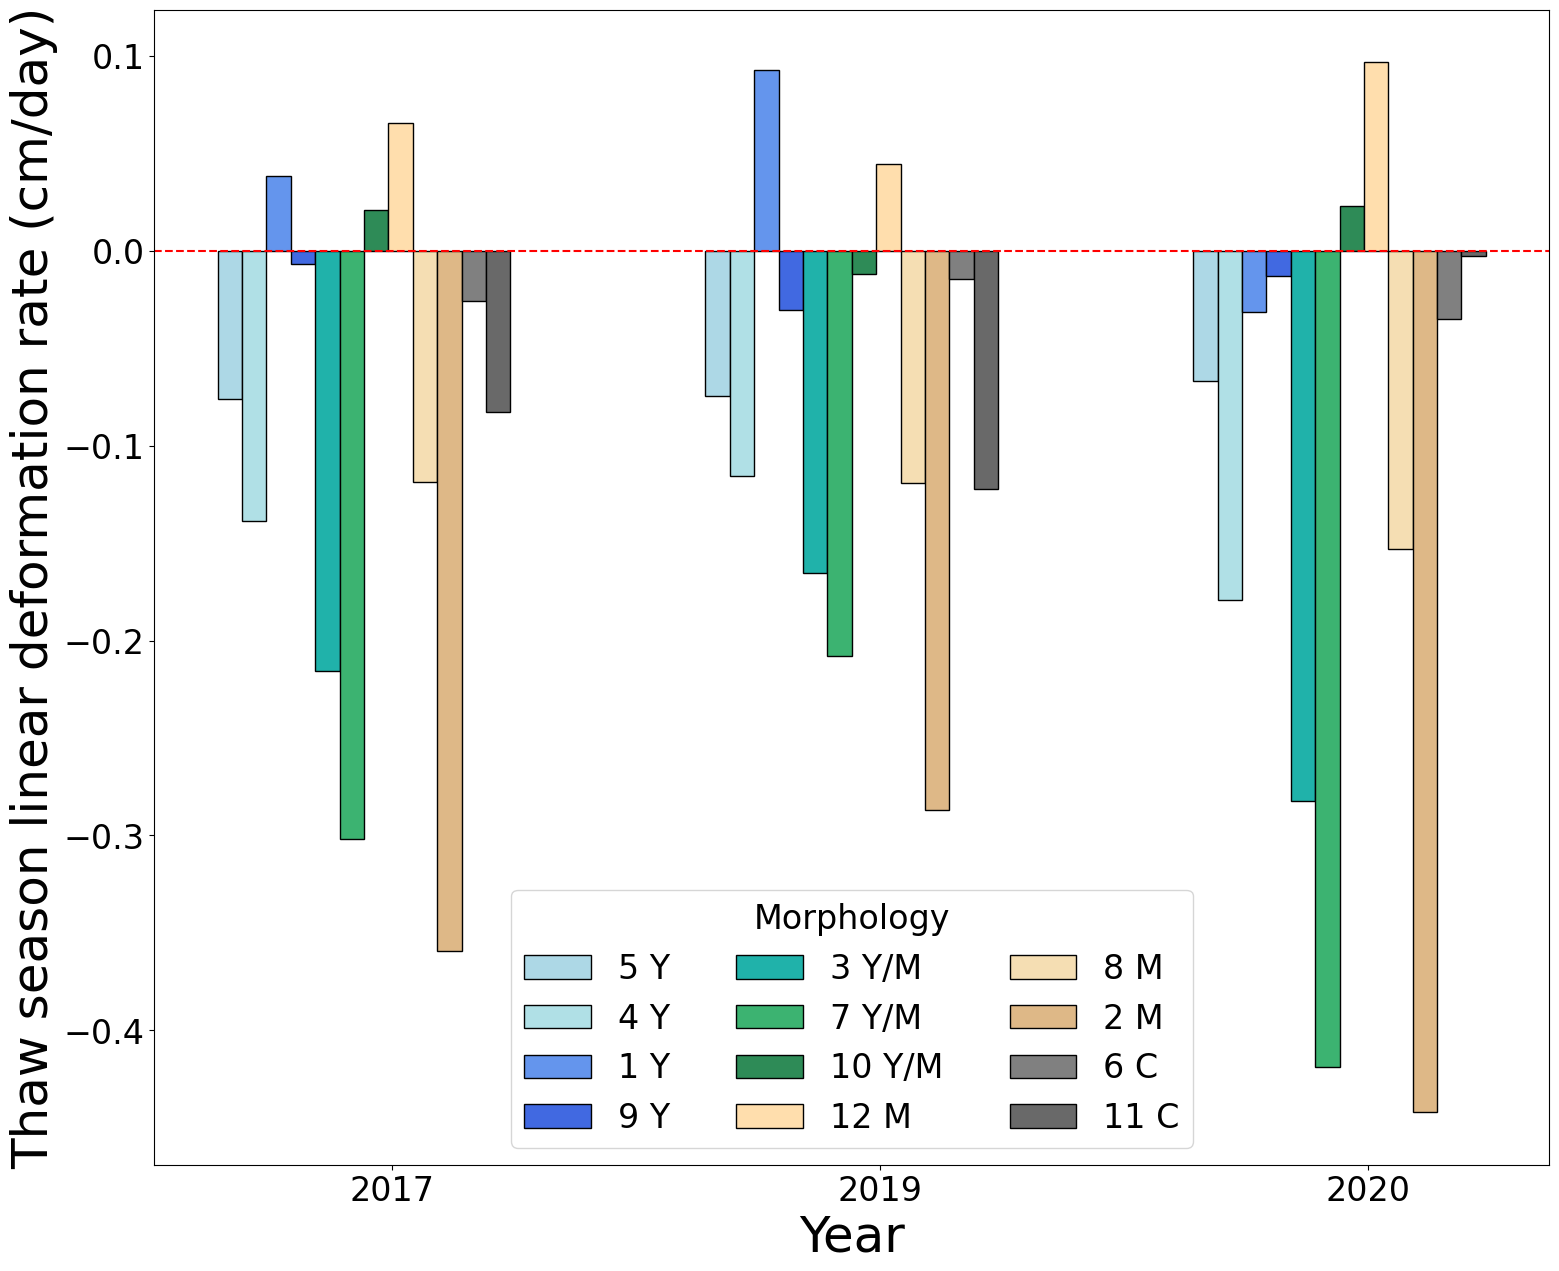

In [48]:
colors =['lightblue','powderblue','cornflowerblue','royalblue','lightseagreen','mediumseagreen','seagreen','navajowhite','wheat','burlywood','grey','dimgrey',]
#hash_p =["..","..","..","..","|||","|||","xx","xx","xx","O","O","O"]
labelp =['5 Y','4 Y','1 Y','9 Y','3 Y/M','7 Y/M','10 Y/M','12 M','8 M','2 M','6 C','11 C']
fig=plt.figure(figsize=(18,15))
for i in range(len(pingos)):
    plt.bar(years_n + years[i]*.15,pingos[i]*100,width=.15,color=colors[i],edgecolor='black', label = labelp[i])
plt.axhline(y=0, color='red', linestyle='--')
#plt.axhline(y=0.1, color='lightgrey', linestyle='--')
#plt.axhline(y=-0.1, color='lightgrey', linestyle='--')
#plt.title('Linear rate of change of summer surface deformation between 2017-2020', fontsize=20)
#plt.axvline(x=2017.44, color='red', linestyle='--')
plt.xlabel('Year', fontsize=36)
plt.ylabel('Thaw season linear deformation rate (cm/day)', fontsize=36)
plt.xticks(years_x[:3],x_years, fontsize=24)
plt.yticks(fontsize=24)
#plt.ylim(-0.46, 0.12)
plt.legend(fontsize="24",title='Morphology', title_fontsize="24",ncols=3)
plt.show()
fig.savefig('rate_plot_no_floor.pdf',dpi=400) 

In [27]:
#filtering data
column = ['Date']
f = pd.read_csv('intlist_36',header=None)
f.columns = column
f = f.iloc[good_scen2]
f['Date'] = f['Date'].str.replace('.int', '')

                  Date
1    20161126_20161220
2    20161220_20170113
3    20170113_20170206
4    20170206_20170302
10   20170314_20170407
..                 ...
197  20201129_20210104
198  20201211_20210104
199  20201223_20210104
200  20201211_20210116
201  20201223_20210116

[108 rows x 1 columns]


/var/folders/5n/p154w9j90cs3nj7gmh1df6nh0000gn/T/ipykernel_44905/1035768718.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  f['Date'] = f['Date'].str.replace('.int', '')


In [28]:
intlist_date = pd.read_csv('intlist_36',  header=None)
int_date = intlist_date[0] #all 270 interferograms = int_date[good_scen2] #108 of original interferograms

In [ ]:
#../S1B_IW_SLC__1SDV_20170630T030505_20170630T030533_006274_00B071_C315.SAFE.geo 
#'../S1B_IW_SLC__1SDV_20170805T030507_20170805T030535_006799_00BF67_F0EE.SAFE.geo',
#series_good_tot2[:,:,13]

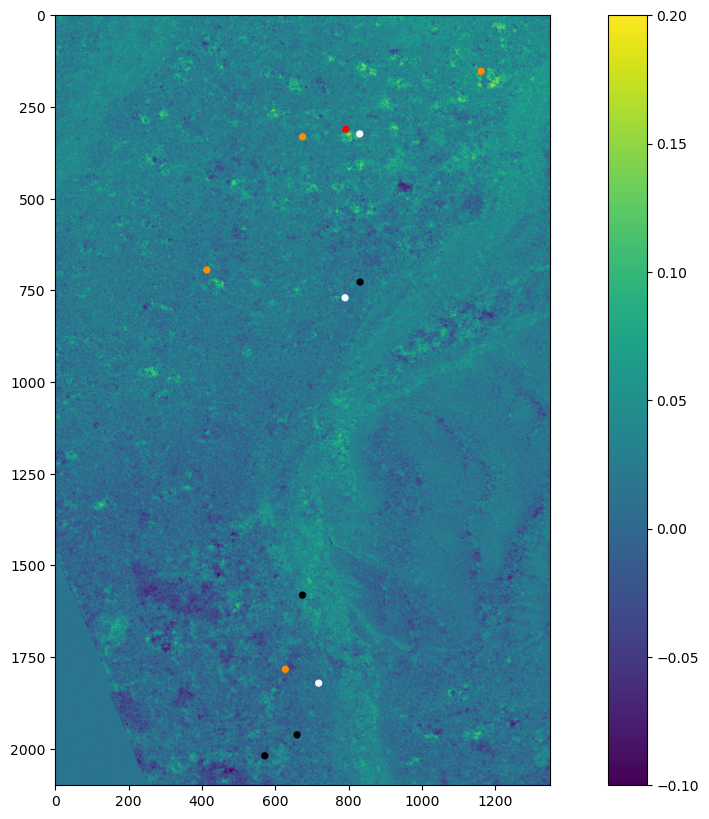

In [51]:
vmin = -0.1
vmax = 0.2
plt.figure(figsize=(15,10))
plt.imshow(series_good_tot2[:,:,15]) 
c2 = plt.Circle((1161,152), 8, fill = 1, color =  'darkorange')
c3 = plt.Circle((792,310), 8, fill = 1, color = 'red')
c4 = plt.Circle((830,323), 8, fill = 1, color = 'ghostwhite')
c5 = plt.Circle((674,331), 8, fill = 1, color = 'darkorange')
c6 = plt.Circle((413,694), 8, fill = 1, color = 'darkorange')
c7 = plt.Circle((831,727), 8, fill = 1, color = 'black')
c8 = plt.Circle((790,770), 8, fill = 1, color = 'ghostwhite')
c9 = plt.Circle((674,1581), 8, fill = 1, color = 'black')
c10 = plt.Circle((627,1783), 8, fill = 1, color = 'darkorange')
c11 = plt.Circle((718,1821), 8, fill = 1, color = 'ghostwhite')
c12 = plt.Circle((659,1962), 8, fill = 1, color = 'black')
c13 = plt.Circle((571,2019), 8, fill = 1, color = 'black')
#t1 = plt.Circle((700,500), 12, fill = 0, color = 'blue') #small uplift, follows the ice agg. 
#t2 = plt.Circle((400,1000), 12, fill = 0, color = 'red')
#t3 = plt.Circle((1100,1250), 12, fill = 0, color = 'red')
plt.gca().add_artist(c2)
plt.gca().add_artist(c3)
plt.gca().add_artist(c4)
plt.gca().add_artist(c5)
plt.gca().add_artist(c6)
plt.gca().add_artist(c7)
plt.gca().add_artist(c8)
plt.gca().add_artist(c9)
plt.gca().add_artist(c10)
plt.gca().add_artist(c11)
plt.gca().add_artist(c12)
plt.gca().add_artist(c13)
#plt.gca().add_artist(t1)
#plt.gca().add_artist(t2)
#plt.gca().add_artist(t3)
plt.clim(vmin,vmax)
plt.colorbar()
plt.show()

In [42]:
#9 pixel clustering function
#need to change independent variable to days from 1st SAR image
def cluster(array,y,x):
    t_days = np.cumsum(dtime_scenes)
    plt.figure(figsize=(10,5))
    plt.title('Surface deformation trends of instrument clustering', fontsize = 14)
    plt.xlabel('Time (Days since first SAR image)', fontsize = 12)
    plt.ylabel('Surface Deformation (cm)', fontsize = 12)
    plt.plot(t_days, array[y,x,0:77]*100, label = 'Center of pingo', color = 'red',linewidth='3')
    plt.plot(t_days, array[y+7,x,0:77]*100, label = 'East', color = 'blue')
    plt.plot(t_days, array[y-7,x,0:77]*100, label = 'West', color = 'black')
    plt.plot(t_days, array[y,x+7,0:77]*100, label = 'North', color = 'orange')
    plt.plot(t_days, array[y,x-7,0:77]*100, label = 'South', color = 'maroon')
    plt.plot(t_days, array[y+7,x+7,0:77]*100, label = 'NE', color = 'green')
    plt.plot(t_days, array[y-7,x+7,0:77]*100, label = 'NW', color = 'magenta')
    plt.plot(t_days, array[y-7,x-7,0:77]*100, label = 'SW', color = 'green')
    plt.plot(t_days, array[y+7,x-7,0:77]*100, label = 'SE', color = 'black')
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
def mean(title,array,y,x):
    #populate list with 9 different arrays
    arr = [array[y,x,0:77],array[y+7,x,0:77],array[y-7,x,0:77],array[y,x+7,0:77],array[y,x-7,0:77],
          array[y+7,x+7,0:77],array[y-7,x+7,0:77],array[y-7,x-7,0:77],array[y+7,x-7,0:77]]
    arr = np.array(arr)*100 #convert m to cm 
    t_days = np.cumsum(dtime_scenes)
    t_days = t_days[0:77]
    #convert to numpy array for processing
    rolling_avg = np.mean(arr, axis = 0)
    std_dev = np.std(arr, axis = 0)

    #perform least squares inversion on rolling_avg 
    def fractional_polynomial(params, x):
        a, b = params
        return a + b * np.power(x, 0.5)
    # Define the residual function
    def residual(params, x, y):
        return fractional_polynomial(params, x) - y
    # Initial guess for the parameters
    initial_params = np.array([1, 1])
    # Fit the data using least squares optimization
    result = least_squares(residual, initial_params, args=(t_days, rolling_avg))
    # Extract the optimized parameters
    optimized_params = result.x
    frac = fractional_polynomial(optimized_params, t_days)
    #calculate R^2 value
    ss_residual = np.sum((rolling_avg - frac) ** 2)
    ss_total = np.sum((rolling_avg - np.mean(rolling_avg)) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    #calculate p-value
    n = len(rolling_avg)
    k = len(optimized_params)
    dof = n - k - 1
    ssr = ss_residual
    mse = ssr / dof
    f_value = (ss_total - ss_residual) / k / mse
    p_value = 1 - stats.f.cdf(f_value, k, dof)
    #calculate RMSE 
    rmse = np.sqrt(np.mean((rolling_avg - frac) ** 2))
    print('rmse =', rmse)
    #print inverted paramters
    print("Optimized parameters:")
    print("a =", optimized_params[0])
    print("b =", optimized_params[1])
    #print statistical values
    print("Statistical Values:")
    print("R^2 =", r_squared)
    print("p value =", p_value)
    #print("RMSE:", rmse)      
    #print(np.squeeze(series_good_tot2[1161,152,77]))
    print("Model-derived Cumulative Uplift (cm): ",frac[-1])
    
    plt.figure(figsize = (10,5))
    plt.title(title, fontsize = 24)
    plt.xlabel('Time (days since first SAR image)', fontsize = 24)
    plt.ylabel('Z(t) (cm)', fontsize = 24)
    plt.scatter(t_days, rolling_avg,label='Mean of clustered pixels', color = 'black')
    plt.plot(t_days, frac,label='Stefan\'s law fit line', color = 'blue',ls='-')
    plt.plot(t_days, rolling_avg - std_dev,label='Std. dev. of avg', color = 'red',ls='--')
    plt.plot(t_days, rolling_avg + std_dev,color = 'red',ls='--')
    y_ticks = ['-8','-6','-4','-2','0','2','4','6','8']
    x_days = ['0','200','400','600','800','1000','1200','1400','1600']
    plt.xticks(np.arange(0,1700,200),x_days, fontsize=18)
    plt.yticks(fontsize=18)
    #plt.yticks(np.arange(-8, 9, 2),y_ticks, fontsize=18)
    plt.ylim(-3,18)
    plt.xlim(0, np.max(t_days)+20)
    plt.grid(False)
    plt.legend()
    plt.show()

rmse = 0.9824136726681143
Optimized parameters:
a = -0.8444517869832684
b = 0.2909236881777265
Statistical Values:
R^2 = 0.8902359834727487
p value = 1.1102230246251565e-16
Model-derived Cumulative Uplift (cm):  10.557381655000615


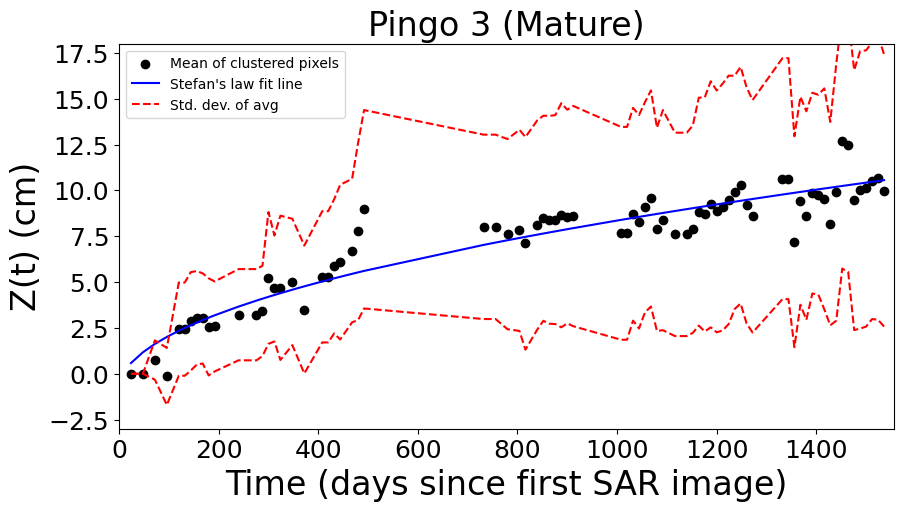

In [45]:
#test
#pingo 3
mean('Pingo 3 (Mature)', series_good_tot2,323,830)

rmse = 0.8669841335310813
Optimized parameters:
a = 0.34594630252198855
b = 0.11647256007628326
Statistical Values:
R^2 = 0.6253517798318887
p value = 2.220446049250313e-16
Model-derived Cumulative Uplift (cm):  4.9107197620828416


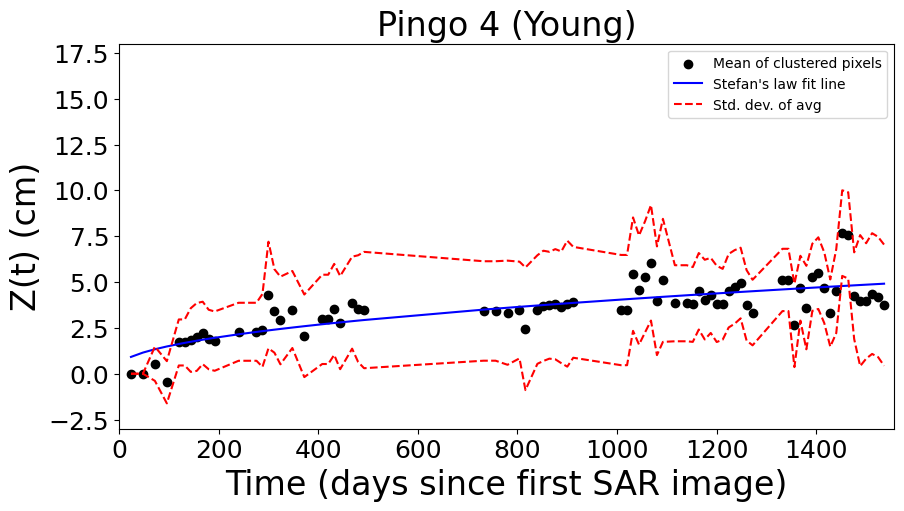

In [46]:
mean('Pingo 4 (Young)', series_good_tot2,331,674)

rmse = 1.4140936154685624
Optimized parameters:
a = -1.9837710456734887
b = 0.2752509268937702
Statistical Values:
R^2 = 0.7779802797695902
p value = 1.1102230246251565e-16
Model-derived Cumulative Uplift (cm):  8.80381810821215


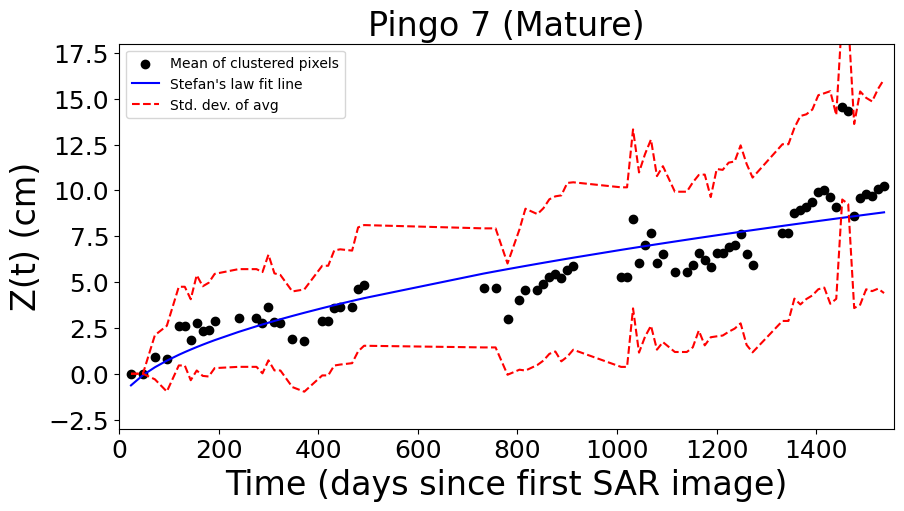

In [47]:
mean('Pingo 7 (Mature)', series_good_tot2,770,790)

rmse = 1.1237852735607292
Optimized parameters:
a = 0.735406410065585
b = 0.24591722846860178
Statistical Values:
R^2 = 0.8157975585387129
p value = 1.1102230246251565e-16
Model-derived Cumulative Uplift (cm):  10.373354069385702


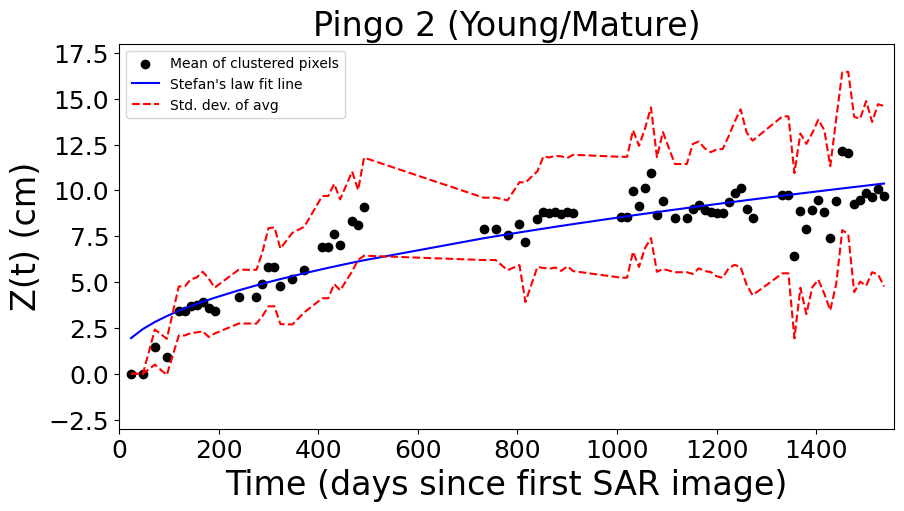

In [48]:
mean('Pingo 2 (Young/Mature)', series_good_tot2,310,792)

rmse = 1.2937607497544086
Optimized parameters:
a = -1.01117755948966
b = 0.18391539166932708
Statistical Values:
R^2 = 0.6514437205651238
p value = 1.1102230246251565e-16
Model-derived Cumulative Uplift (cm):  6.196804287453818


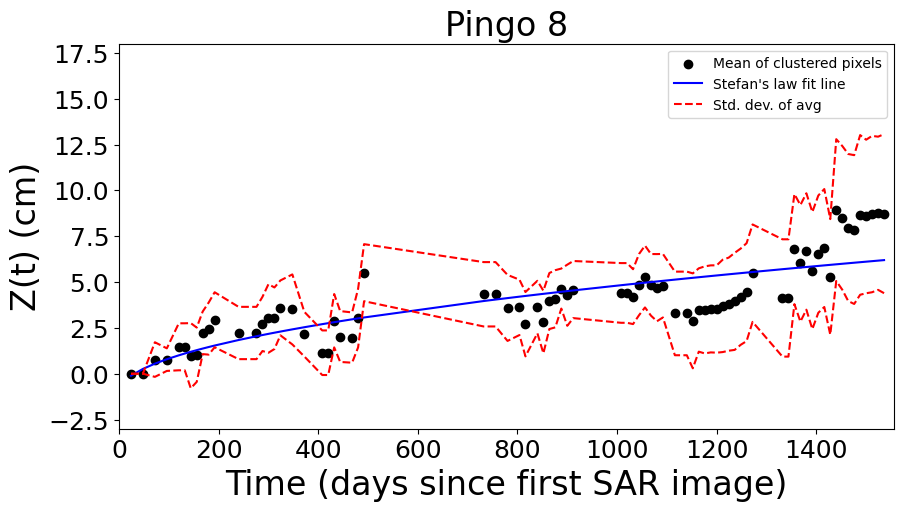

In [50]:
mean('Pingo 8', series_good_tot2,1581,674)

rmse = 1.1712689053265048
Optimized parameters:
a = 0.5519261833377852
b = 0.022174645020378657
Statistical Values:
R^2 = 0.032085792565139326
p value = 0.2992016555315531
Model-derived Cumulative Uplift (cm):  1.4209912317741948


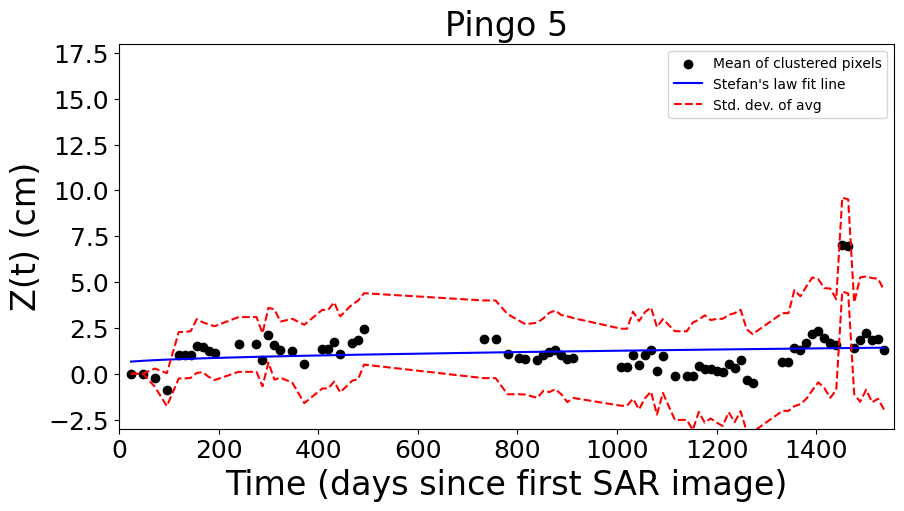

In [53]:
mean('Pingo 5', series_good_tot2,694,413)

rmse = 1.166241918608814
Optimized parameters:
a = 1.3070432006069919
b = 0.13326260419040337
Statistical Values:
R^2 = 0.5470148068028143
p value = 1.8840484727888906e-13
Model-derived Cumulative Uplift (cm):  6.529849313582473


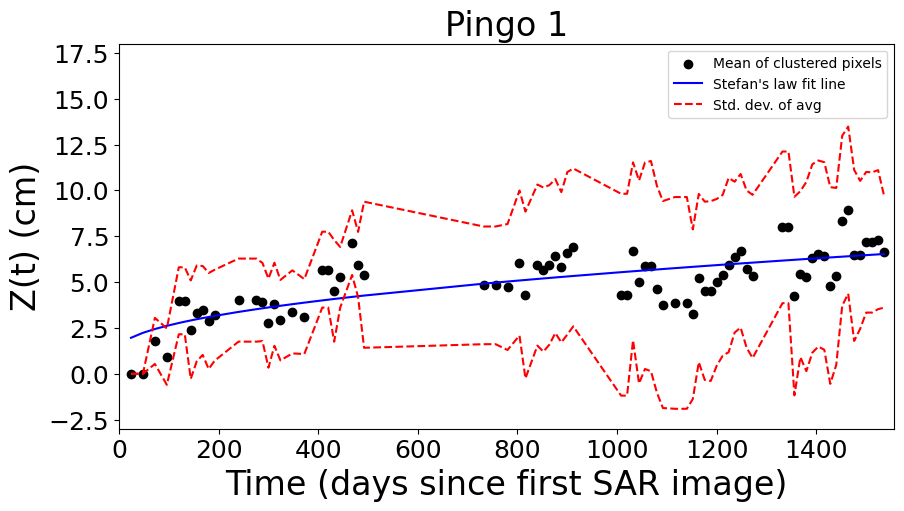

In [54]:
mean('Pingo 1', series_good_tot2, 152,1161)

rmse = 1.1421474691508835
Optimized parameters:
a = 0.3238810616167028
b = 0.04251130065475848
Statistical Values:
R^2 = 0.11357487181939219
p value = 0.011554633564660022
Model-derived Cumulative Uplift (cm):  1.9899769801159457


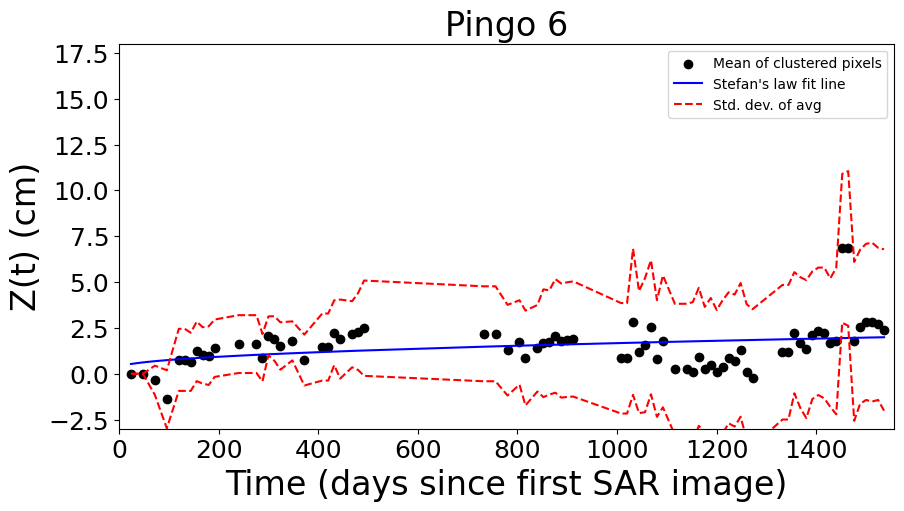

In [55]:
mean('Pingo 6', series_good_tot2, 727,831)

rmse = 1.084029464231205
Optimized parameters:
a = 1.8335356433815475
b = -0.1009847071093518
Statistical Values:
R^2 = 0.44524898288803716
p value = 3.401182668838487e-10
Model-derived Cumulative Uplift (cm):  -2.1242404244955835


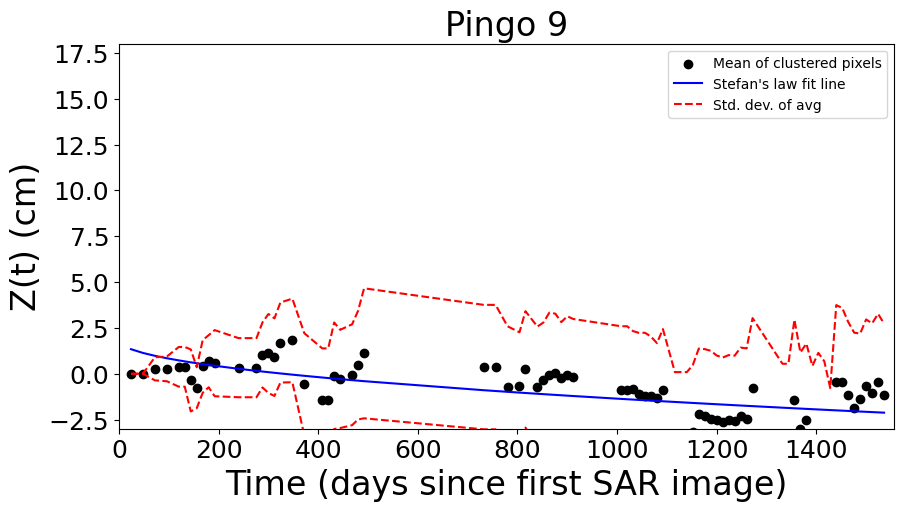

In [56]:
mean('Pingo 9', series_good_tot2,1783,627)

rmse = 1.22346131128511
Optimized parameters:
a = 0.6721750834240126
b = 0.001738524751200544
Statistical Values:
R^2 = 0.0001867134225937983
p value = 0.9931147708946795
Model-derived Cumulative Uplift (cm):  0.7403110601542591


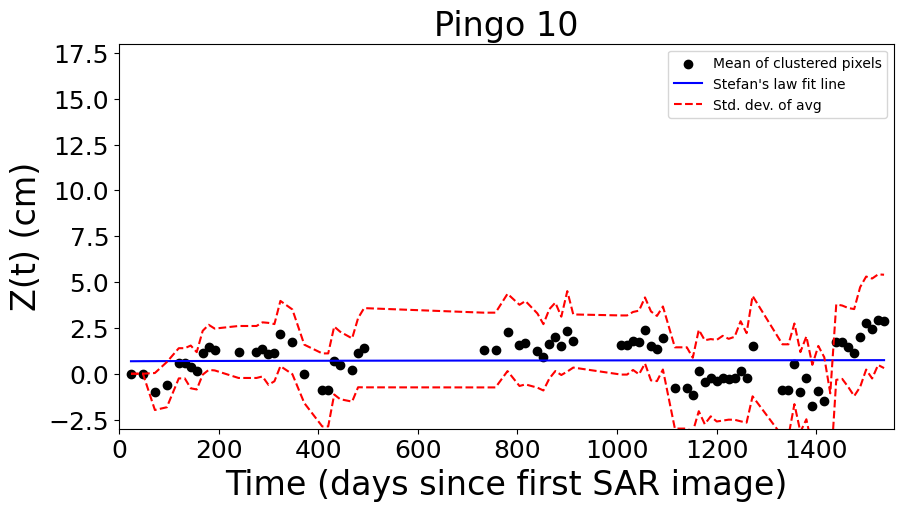

In [57]:
mean('Pingo 10', series_good_tot2,1821,718)

rmse = 1.4550036450747643
Optimized parameters:
a = 2.95300468798672
b = -0.15712095881297475
Statistical Values:
R^2 = 0.5188813443882847
p value = 1.7511547767412594e-12
Model-derived Cumulative Uplift (cm):  -3.2048541438315166


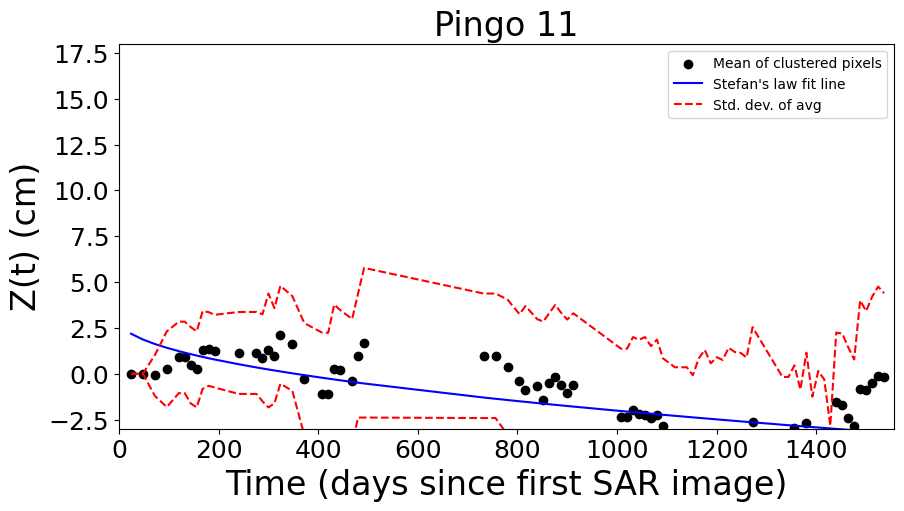

In [58]:
mean('Pingo 11', series_good_tot2,1962,659)

rmse = 1.5446385320355596
Optimized parameters:
a = 2.126400414505825
b = -0.11147470747639013
Statistical Values:
R^2 = 0.3250985827009061
p value = 4.807204373458163e-07
Model-derived Cumulative Uplift (cm):  -2.2424980261849403


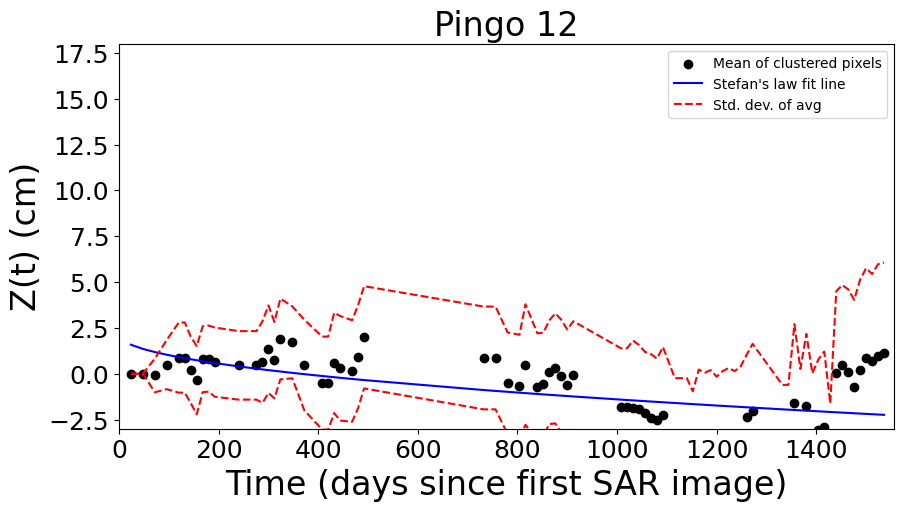

In [59]:
mean('Pingo 12', series_good_tot2,2019,571)

Optimized parameters:
a = -0.7321828171969946
b = 0.07881244099123245
Statistical Values:
R^2 = 0.43675975364409836
p value = 5.965765659254885e-10
RMSE: 0.008607126836746587
Model-derived Cumulative Uplift (cm):  2.356621435790659


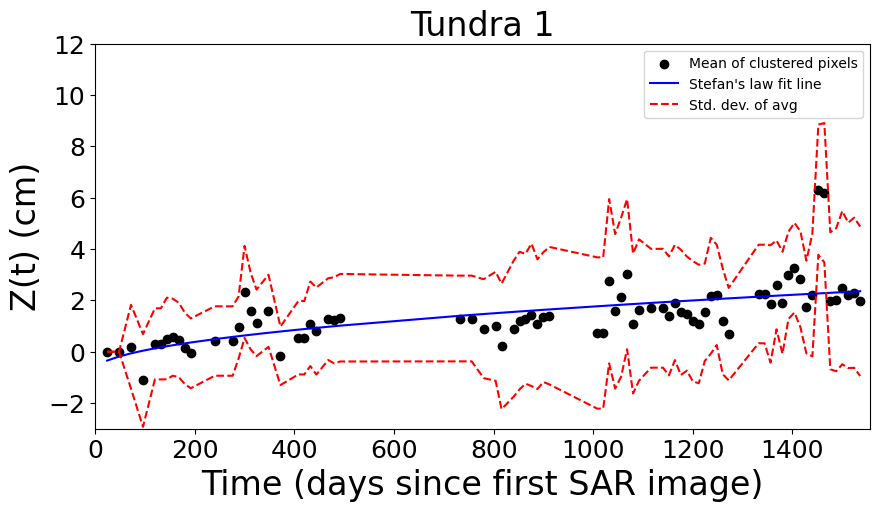

In [396]:
mean('Tundra 1', series_good_tot2,500,700)

Optimized parameters:
a = 1.2875876047445294
b = -0.05015322282019805
Statistical Values:
R^2 = 0.2063605730551228
p value = 0.00019322338652028037
RMSE: 0.009458777102487702
Model-derived Cumulative Uplift (cm):  -0.67800927310498


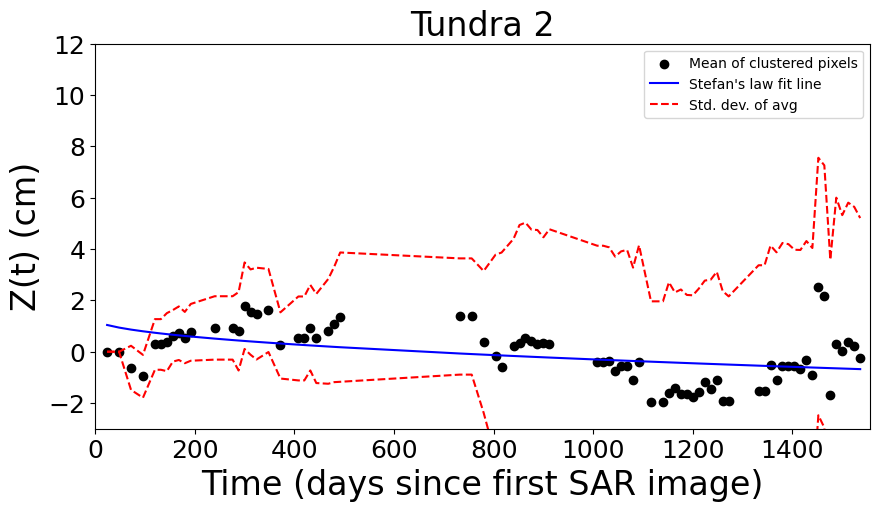

In [397]:
mean('Tundra 2', series_good_tot2,1000,400)

Optimized parameters:
a = 4.2426985844502765
b = -0.2022341628307691
Statistical Values:
R^2 = 0.6976252076514492
p value = 1.1102230246251565e-16
RMSE: 0.012804249295687742
Model-derived Cumulative Uplift (cm):  -3.6832295354587137


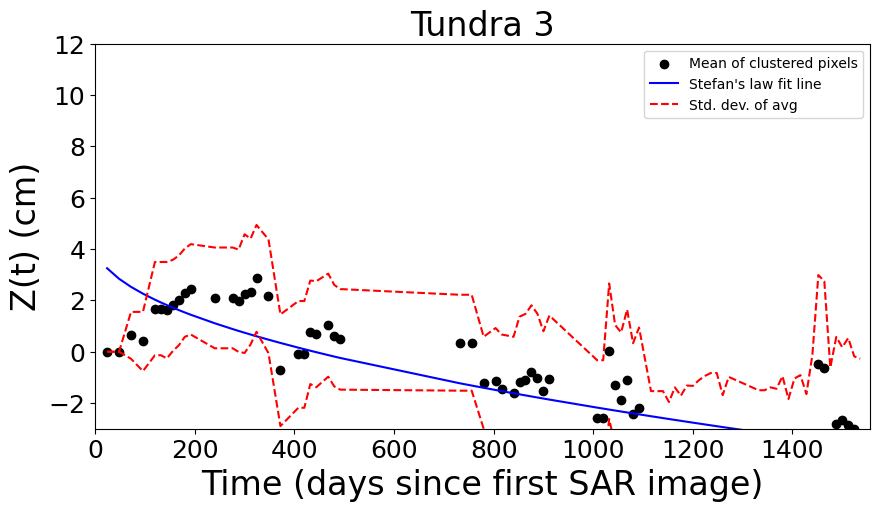

In [398]:
mean('Tundra 3', series_good_tot2,1250,1100)

In [399]:
#def invert_3p(x_d,y_d,title):
#    
#    t_days = np.cumsum(dtime_scenes)
#    t_days = t_days[0:77]
#    z = series_good_tot2[x_d,y_d,:]
#    z = z[0:77]
#    # Define the fractional polynomial function
#    def fractional_polynomial(params, x):
#        b1, b2, b3 = params
#        if 0 < b3 < 1:
#            return b1 + b2 * np.power(x, b3)
#        else:
#            return np.inf
#    # Define the residual function
#    def residual(params, x, y):
#        return fractional_polynomial(params, x) - y
#    # Fit the data using least squares optimization
#    result = least_squares(residual, x0=[1, 1, 0.5], args=(t_days, z))
#    # Extract the optimized parameters
#    optimized_params = result.x
#    # Implement new parameters to polynomial function 
#    frac = fractional_polynomial(optimized_params, t_days)
#    print(optimized_params[2])
#    #calculate R^2 value
#    ss_residual = np.sum((z - frac) ** 2)
#    ss_total = np.sum((z - np.mean(z)) ** 2)
#    r_squared = 1 - (ss_residual / ss_total)
#    #calculate p-value
#    n = len(z)
#    k = len(optimized_params)
#    dof = n - k - 1
#    ssr = ss_residual
#    mse = ssr / dof
#    f_value = (ss_total - ss_residual) / k / mse
#    p_value = 1 - stats.f.cdf(f_value, k, dof)
#    #calculate RMSE 
#    rmse = np.sqrt(np.mean((z - frac) ** 2))
#    # Print the optimized parameters
#    print("Optimized parameters:")
#    print("b1 =", optimized_params[0])
#    print("b2 =", optimized_params[1])
#    print("b3 =", optimized_params[2])
#    #print statistical values
#    print("Statistical Values:")
#    print("R^2 =", r_squared)
#    print("p value =", p_value)
#    print("RMSE:", rmse)     
#    #visualize results
#    plt.figure(figsize = (10,5))
#    plt.title(title, fontsize = 14)
#    plt.xlabel('Time', fontsize = 12)
#    plt.ylabel('Change in Surface Height (m)', fontsize = 12)
#    plt.plot(t_days,z*100,label='Pingo surface deformation changes', color = 'black')
#    plt.plot(t_days, frac*100,label='Fractional fit line', color = 'red',ls='--')
#    x = np.arange(0,108,1)
#    plt.legend()
#    plt.grid(True)
#    plt.show()
    
#    return frac

In [400]:
#CALCULATE THE RATE OF ICE AGGRADATION#

In [401]:
#calculate TOTAL rate of ice aggradation
def ice_tot(x,y):
    z = series_good_tot2[x,y,0:77]*100 #returning cm measurements
    t = np.cumsum(dtime_scenes)
    rate = (z[-1] - z[0]) / (t[-1] - t[0])
    rate = rate * 365 *5 #returning cm/5year period 
    
    return rate

In [402]:
ice_tot(770,790)

np.float64(21.177747808224385)

In [109]:
pin_x = [152,310,323,331,694,727,770,1581,1783,1821,1962]
pin_y = [1161,792,830,674,413,831,790,674,627,718,659,571]
year = ['2016','2017','2018','2019','2020','2021']

In [404]:
ice_agg_tot = []
for i in range(len(pin_x)):
    ice_agg_tot.append(ice_tot(pin_x[i],pin_y[i]))
print(ice_agg_tot)

[np.float64(-0.1677455415789762), np.float64(9.209115539848936), np.float64(10.536299931631966), np.float64(0.8934262766619401), np.float64(-1.828489021834032), np.float64(-1.530967798080617), np.float64(21.177747808224385), np.float64(11.42772501527128), np.float64(-2.842936149184684), np.float64(0.25316588213240165), np.float64(-6.6127347602483955)]


In [111]:
#calculate rate of ice aggradation - annual
def ice_ann(x,y,int_date,year):
    
    #calculate length of 3rd index based on year input 
    num = int_date.str.contains(year)
    new, new_idx = [], []
    for idx, x in enumerate(int_date):
         if num[idx] == True:
             #store array values
             new.append(x)
             #store idx values
             new_idx.append(idx)  
    #print(new_idx,new)
    z = []
    t = []
    for idx, x in enumerate(new_idx):
        z.append(series_good_tot2[x,y,idx]*100)
        t.append(dtime_ints[idx])
    z = z
    t = np.cumsum(t)
    rate = (z[-1] - z[0])  #cm/year 
    return rate

In [112]:
ice_ann(770,790,int_date,'2021')

7.064491168391143

In [110]:
ice_agg_ann = []
for i in range(len(pin_x)):
        ice_agg_ann.append(ice_ann(pin_x[i],pin_y[i],int_date,'2018'))
print(ice_agg_ann)

[0.008243781313352221, 0.00871279226447791, 0.014498764682272382, 0.011349358063614663, 0.0022896266395275866, 0.014322806341136595, 0.008315038430043857, 0.011349358063614663, 0.006056421668322785, 0.005252924135644424, 0.005293817827583005]


In [408]:
### extracting height at exact lat and long positions ###

In [409]:
lats = np.array([70.17724856,70.13333716,70.12982527,70.12746419,70.02672475,
            70.0173919,70.00551375,69.78014359,69.72408264,69.71349947,
            69.67455965,69.65860005,68.73812003,68.73593044,68.7347436],dtype='float64')
longs = np.array([-148.5571576,-148.7619528,-148.7413219,-148.8279025,-148.9725783,
             -148.7403453,-148.7632876,-148.8279091,-148.8537984,-148.8034669,
             -148.8361065,-148.8852182,-148.9497901,-148.8490479,-148.8574765],dtype='float64')

In [410]:
#new method to use lat/long -> get pixel on image
def world_to_pixel(geo_matrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

#extract target reference from tiff file
ds = gdal.Open('elevation.dem')
target = osr.SpatialReference(wkt=ds.GetProjection())

source = osr.SpatialReference()
source.ImportFromEPSG(4326)

transform = osr.CoordinateTransformation(source, target)
point = ogr.Geometry(ogr.wkbPoint)
#lon,lat
point.AddPoint(-148.9497901,68.73812003)
point.Transform(transform)

x,y = world_to_pixel(ds.GetGeoTransform(), point.GetX(), point.GetY())
print(x,y)

3481 10567


In [411]:
# pingo pixel locations on DEM
#x = np.array([5978,4676,4807,4256,3337,4813,4667,4256,4092,4412,4204,3892])
#y = np.array([1416,1695,1718,1733,2373,2433,2508,3941,4297,4365,4612,4714])
array = ds.GetRasterBand(1).ReadAsArray()
x = np.array([4676,4807,4256,4667,4256])
y = np.array([1695,1718,1733,2508,3941])

In [412]:
#visualize DEM 
#plt.imshow(array)
#plt.colorbar()

In [413]:
#setting inputs up for formation function
elev = np.zeros((5,1))  #z0 input
for i in range(len(x)):
    elev[i] = array[x[i],y[i]]
#pingo: 2,3,4,7,8
b0 = np.array([0.0013891455929829306,0.0019446218717669454,0.0005220620351619227,
              0.0041274392831240556,0.0018169916655504242])

In [414]:
def tundra_elev(x,y):
    arr = np.array((array[x,y+5],array[x+5,y]
                   ,array[x,y-5],array[x-5,y]))
    print(arr)
    arr = np.mean(arr)
    return arr

In [415]:
pin2elev = tundra_elev(x[0],y[0])

[143 143 141 142]


In [416]:
print(elev[0]-pin2elev)

[-0.25]


In [417]:
#CALCULATE ESTIMATED YEAR OF FORMATION#

In [418]:
#calculate time period of pingo initial formation
#need to determine current height of pingo
#need to determine b0...
#def formation(z0,b0):
#    c0 = 2
#    t0 = (z0/b0) ** c0
#    t0 =t0
#    return t0 /365  

In [419]:
#formation(3,0.0013891455929829306)

In [420]:
## Implementing F-test ##

In [421]:
group1 = series_good_tot2[790,770,:]
group2 = series_good_tot2[790,772,:]
x = np.array(group1)
y = np.array(group2)
#print(np.var(group1), np.var(group2))

def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = x.size-1
    dun = y.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    return f, p_value

# perform F-test
f_test(x, y)

(np.float64(3.8292385300372), np.float64(7.062902596111087e-09))

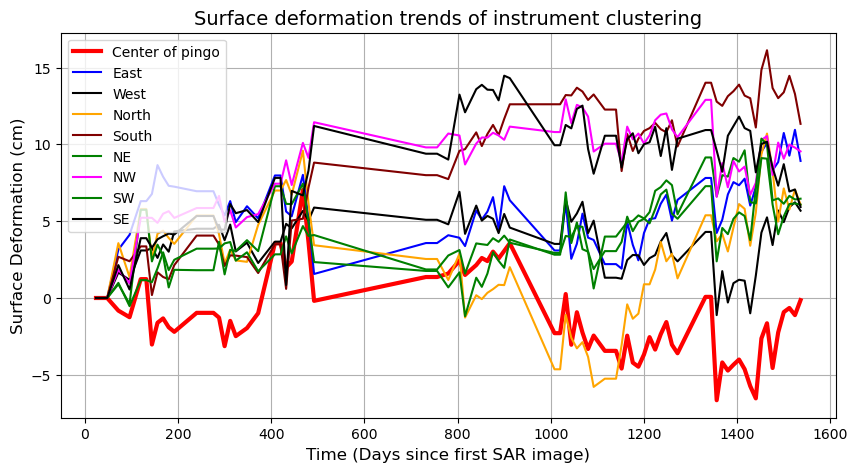

Optimized parameters:
a = 1.3070431785467165
b = 0.1332626048933504
Statistical Values:
R^2 = 0.5470148068028144
p value = 1.8840484727888906e-13
RMSE: 0.01166241918608814
Model-derived Cumulative Uplift (cm):  6.529849319071983


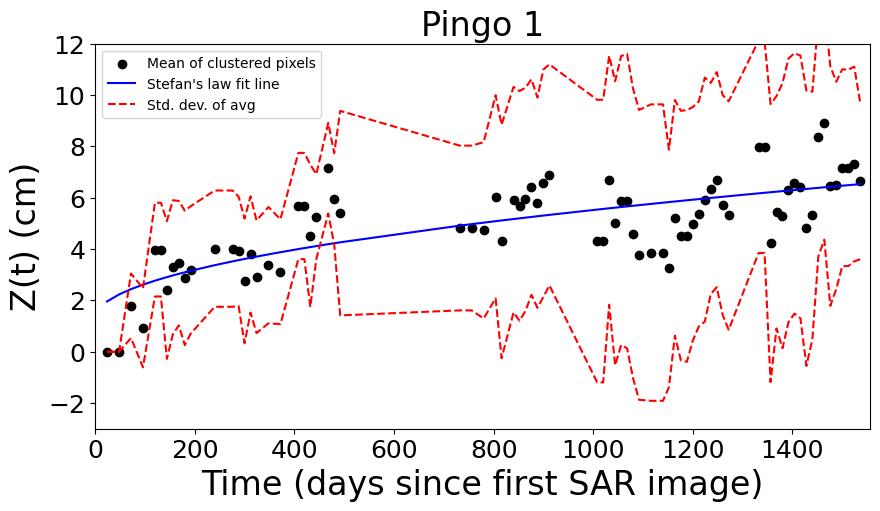

-0.014457250254602871
(2100, 1350, 78)


In [422]:
#plotting clustered raw data
#1 pixel out
cluster(series_good_tot2, 152,1161)

#plotting running average and std dev of clustered pix
mean('Pingo 1',series_good_tot2, 152, 1161)
print(np.squeeze(series_good_tot2[1161,152,77]))
print(series_good_tot2.shape)

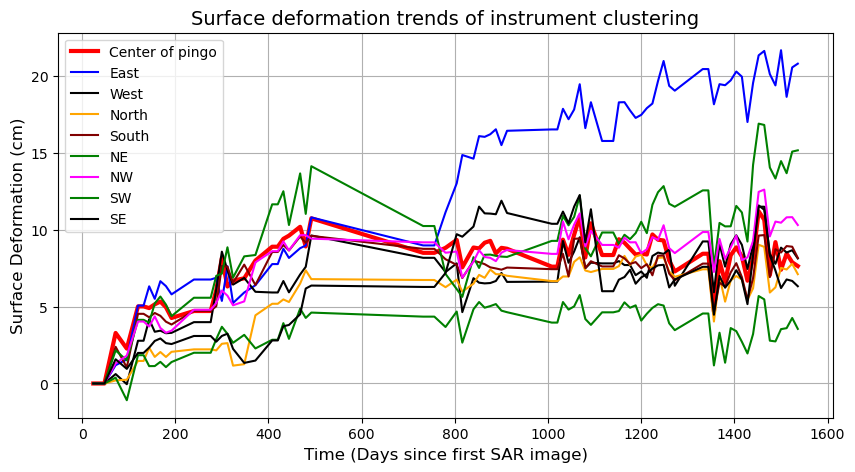

Optimized parameters:
a = 0.7354064058947127
b = 0.24591722872439947
Statistical Values:
R^2 = 0.8157975585387133
p value = 1.1102230246251565e-16
RMSE: 0.01123785273560729
Model-derived Cumulative Uplift (cm):  10.373354075240012


<Figure size 640x480 with 0 Axes>

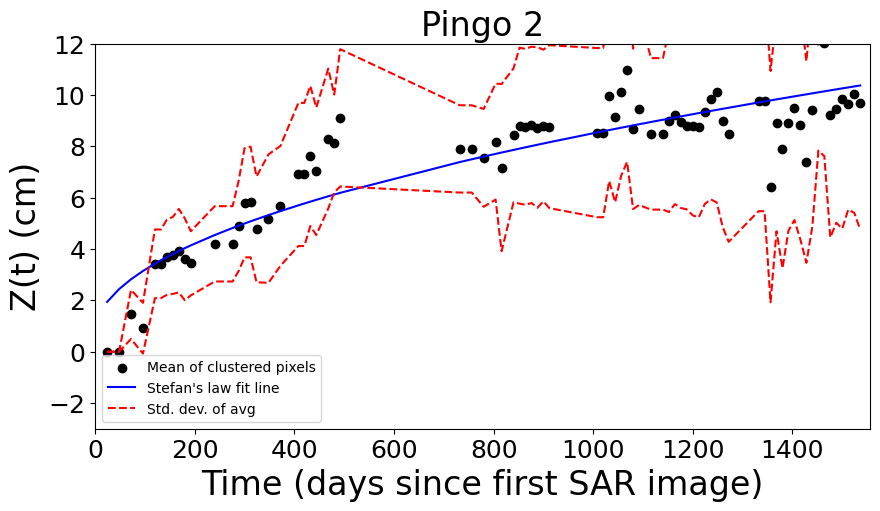

In [423]:
#plotting clustered raw data
cluster(series_good_tot2, 310, 792)
plt.suptitle('Pingo 2')

#plotting running average and std dev of clustered pix
mean('Pingo 2',series_good_tot2, 310, 792)

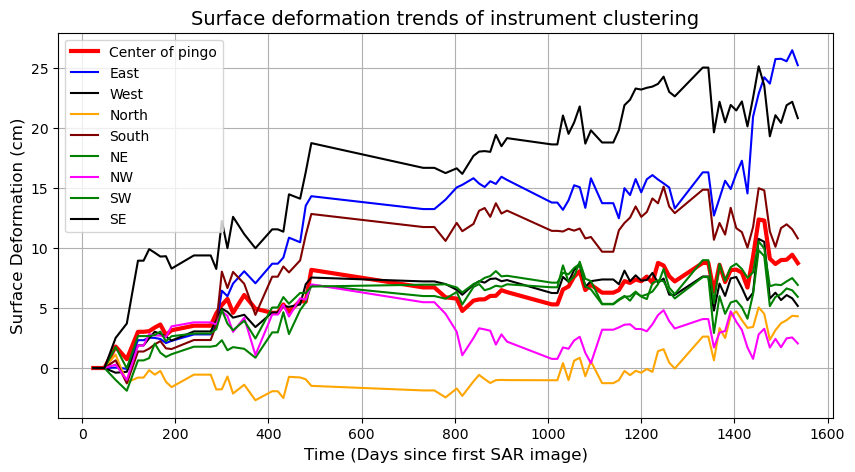

Optimized parameters:
a = -0.8444517880382587
b = 0.2909236882134093
Statistical Values:
R^2 = 0.8902359834727487
p value = 1.1102230246251565e-16
RMSE: 0.009824136726681143
Model-derived Cumulative Uplift (cm):  10.5573816553441


<Figure size 640x480 with 0 Axes>

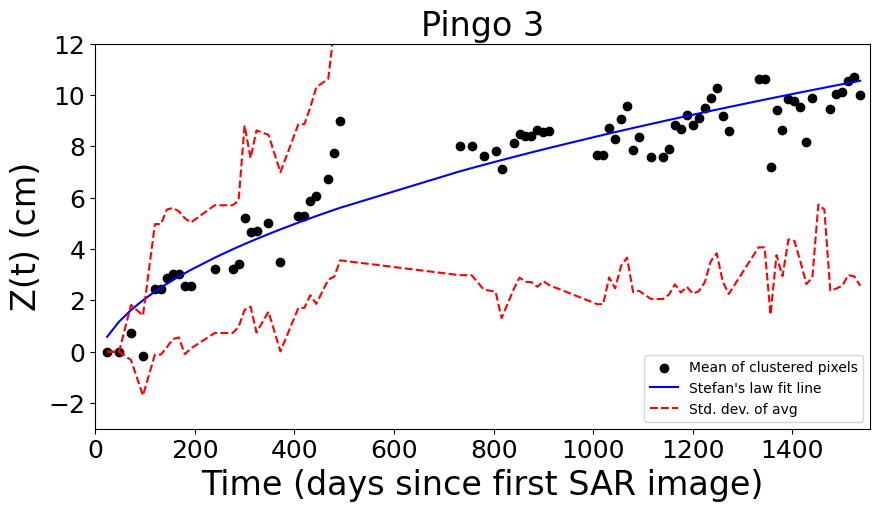

In [424]:
#plotting clustered raw data
cluster(series_good_tot2, 323, 830)
plt.suptitle('Pingo 3')

#plotting running average and std dev of clustered pix
mean('Pingo 3',series_good_tot2, 323, 830)

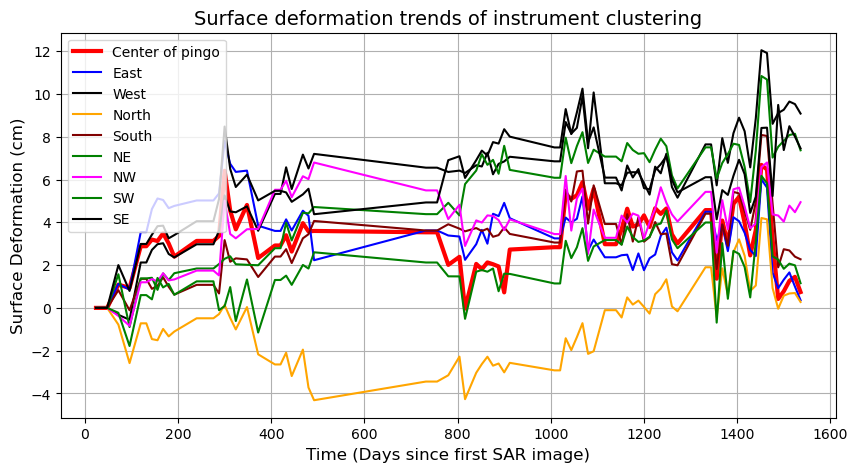

Optimized parameters:
a = 0.3459463374389298
b = 0.11647255899240506
Statistical Values:
R^2 = 0.6253517798318896
p value = 2.220446049250313e-16
RMSE: 0.008669841335310813
Model-derived Cumulative Uplift (cm):  4.910719754520606


<Figure size 640x480 with 0 Axes>

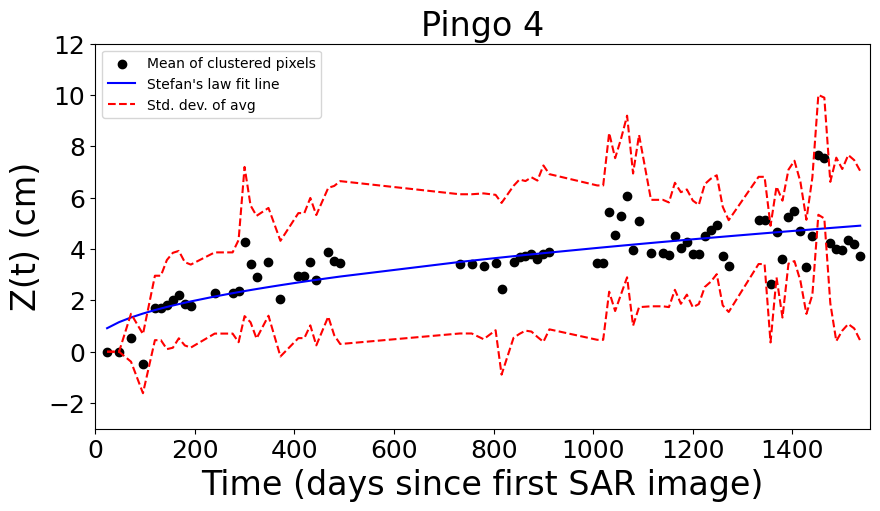

In [425]:
#plotting clustered raw data
cluster(series_good_tot2, 331, 674)
plt.suptitle('Pingo 4')

#plotting running average and std dev of clustered pix
mean('Pingo 4',series_good_tot2, 331, 674)

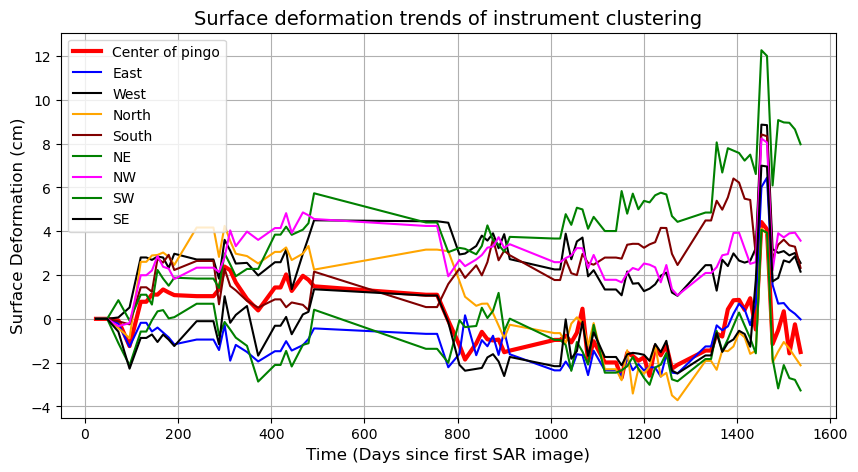

Optimized parameters:
a = 0.5519261834317533
b = 0.022174645017002177
Statistical Values:
R^2 = 0.032085792565140214
p value = 0.29920165553154154
RMSE: 0.011712689053265052
Model-derived Cumulative Uplift (cm):  1.4209912317358322


<Figure size 640x480 with 0 Axes>

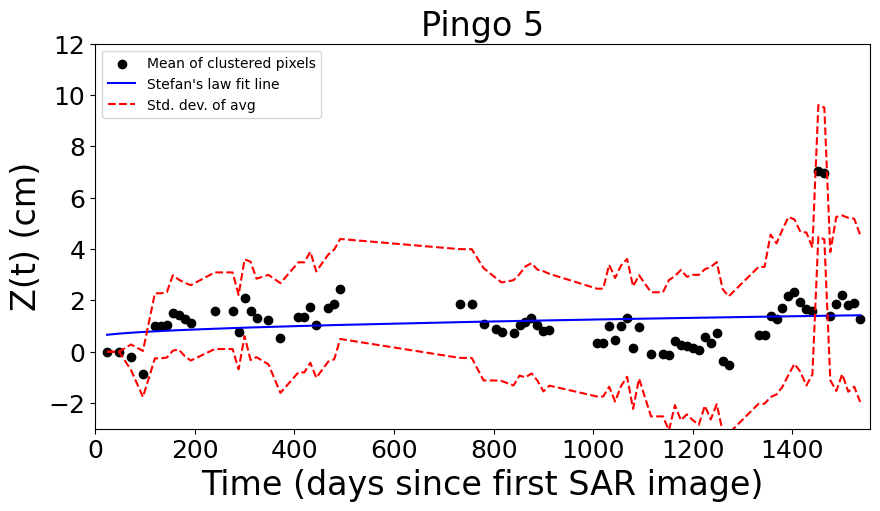

In [426]:
##plotting clustered raw data
cluster(series_good_tot2, 694, 413)
plt.suptitle('Pingo 5')

#plotting running average and std dev of clustered pix
mean('Pingo 5',series_good_tot2, 694, 413)

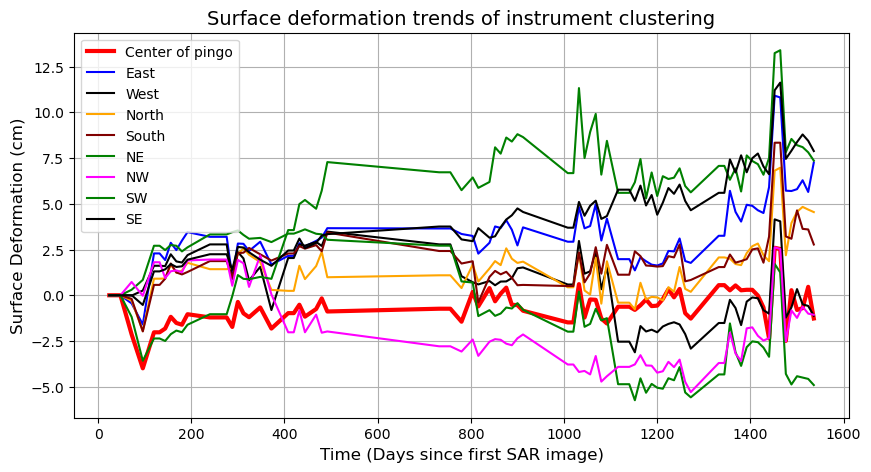

Optimized parameters:
a = 0.3238810707085539
b = 0.042511300361988795
Statistical Values:
R^2 = 0.11357487181939285
p value = 0.011554633564659689
RMSE: 0.011421474691508839
Model-derived Cumulative Uplift (cm):  1.9899769777336154


<Figure size 640x480 with 0 Axes>

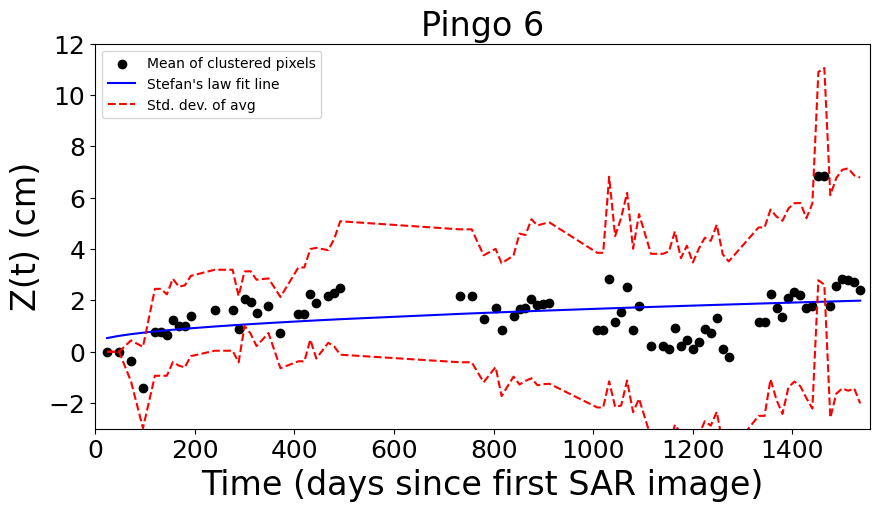

In [427]:
#plotting clustered raw data
cluster(series_good_tot2, 727, 831)
plt.suptitle('Pingo 6')

#plotting running average and std dev of clustered pix
mean('Pingo 6',series_good_tot2, 727, 831)

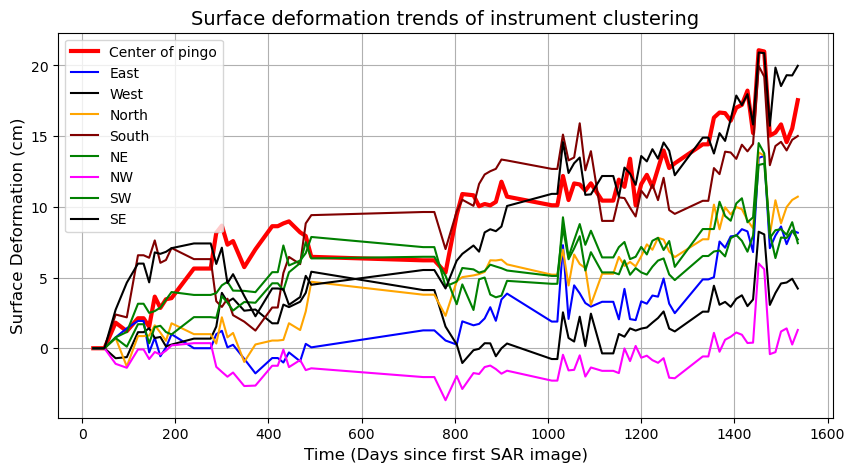

Optimized parameters:
a = -1.983771040551569
b = 0.27525092673630225
Statistical Values:
R^2 = 0.77798027976959
p value = 1.1102230246251565e-16
RMSE: 0.014140936154685639
Model-derived Cumulative Uplift (cm):  8.803818107162613


<Figure size 640x480 with 0 Axes>

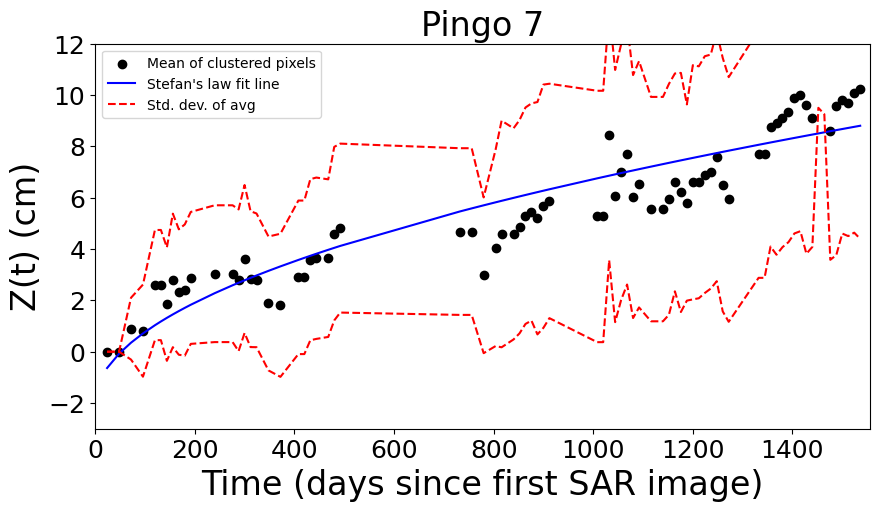

In [428]:
#plotting clustered raw data
cluster(series_good_tot2, 770, 790)
plt.suptitle('Pingo 7')

#plotting running average and std dev of clustered pix
mean('Pingo 7',series_good_tot2, 770, 790)

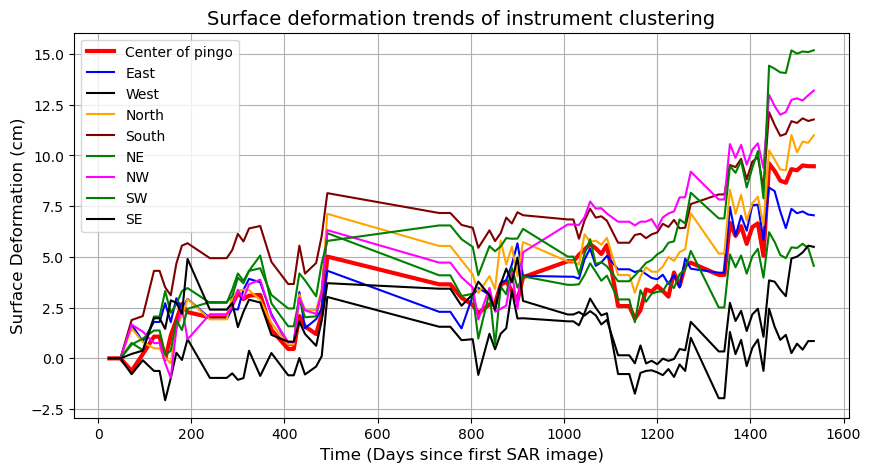

Optimized parameters:
a = -1.0111775585677427
b = 0.18391539163132267
Statistical Values:
R^2 = 0.6514437205651233
p value = 1.1102230246251565e-16
RMSE: 0.01293760749754409
Model-derived Cumulative Uplift (cm):  6.196804286886273


<Figure size 640x480 with 0 Axes>

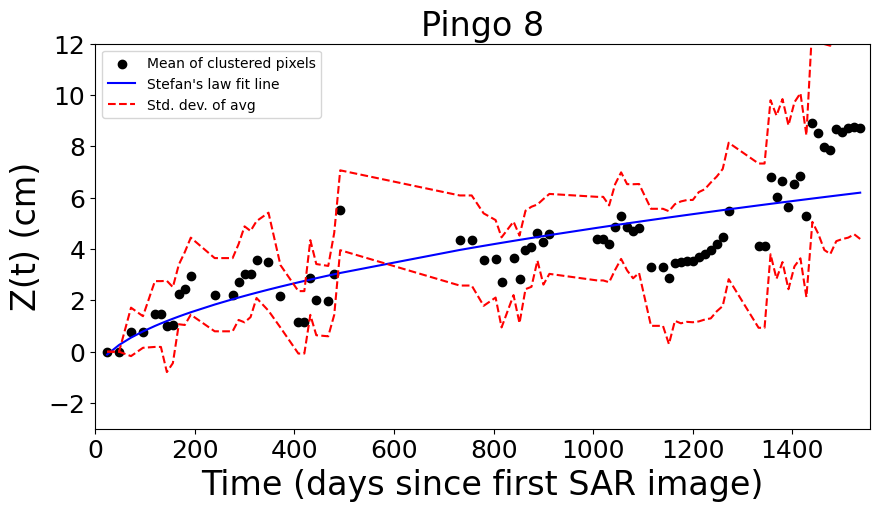

In [429]:
#plotting clustered raw data
cluster(series_good_tot2, 1581, 674)
plt.suptitle('Pingo 8')

#plotting running average and std dev of clustered pix
mean('Pingo 8',series_good_tot2, 1581, 674)

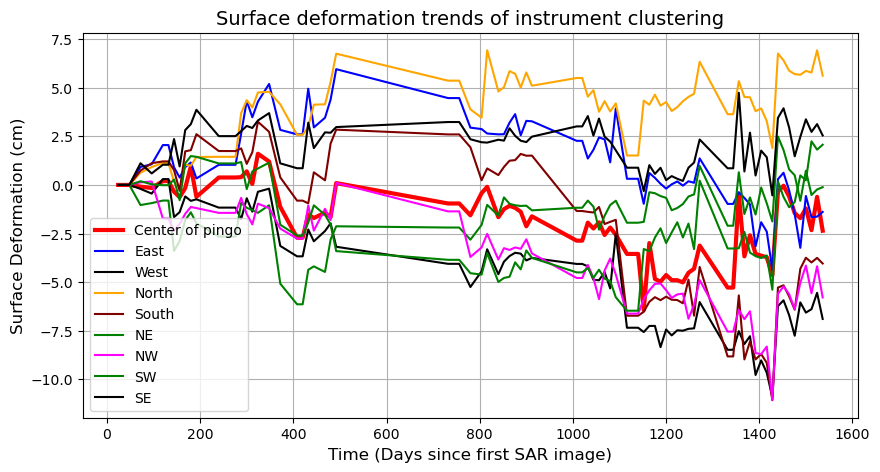

Optimized parameters:
a = 1.833535612961982
b = -0.10098470613272194
Statistical Values:
R^2 = 0.44524898288803805
p value = 3.401182668838487e-10
RMSE: 0.010840294642312048
Model-derived Cumulative Uplift (cm):  -2.124240416639232


<Figure size 640x480 with 0 Axes>

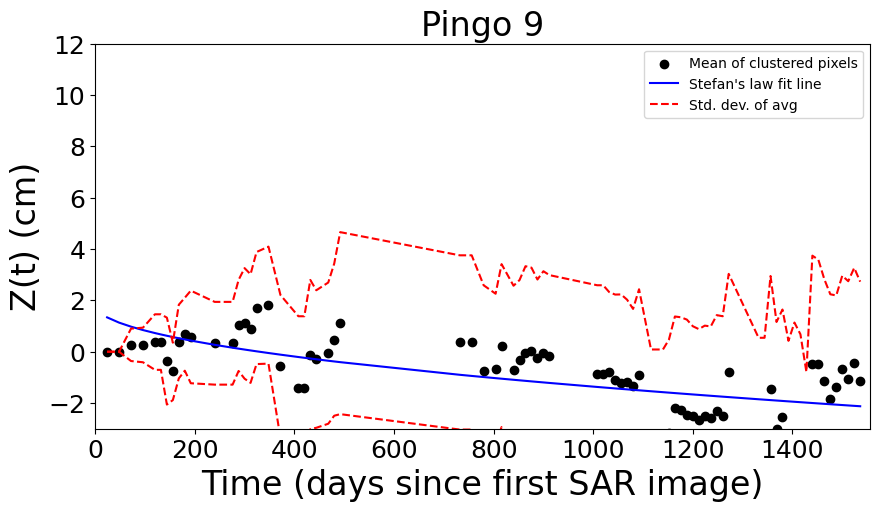

In [430]:
#plotting clustered raw data
cluster(series_good_tot2, 1783, 627)
plt.suptitle('Pingo 9')

#plotting running average and std dev of clustered pix
mean('Pingo 9',series_good_tot2, 1783, 627)

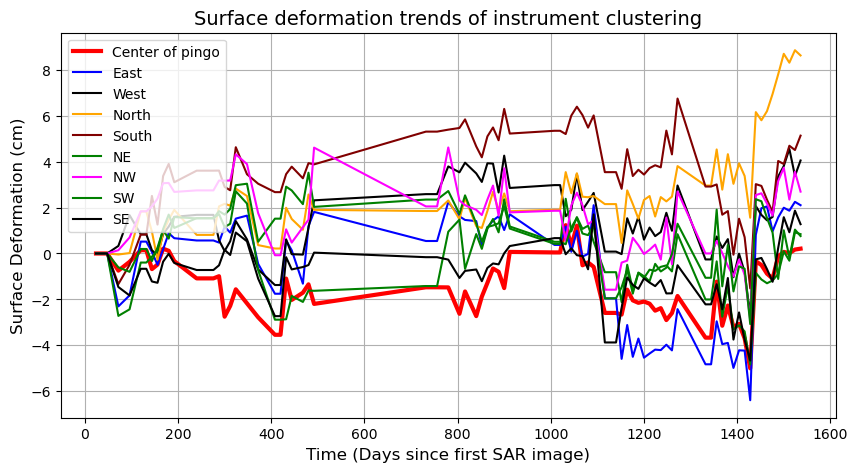

Optimized parameters:
a = 0.6721751099416642
b = 0.0017385238986362408
Statistical Values:
R^2 = 0.00018671342259346524
p value = 0.993114770894693
RMSE: 0.012234613112851097
Model-derived Cumulative Uplift (cm):  0.7403110532583504


<Figure size 640x480 with 0 Axes>

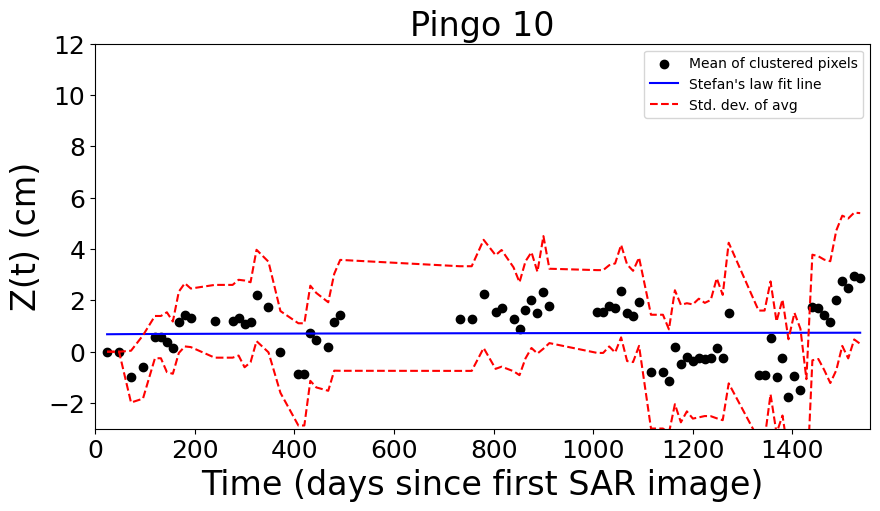

In [431]:
#plotting clustered raw data
cluster(series_good_tot2, 1821, 718)
plt.suptitle('Pingo 10')

#plotting running average and std dev of clustered pix
mean('Pingo 10',series_good_tot2, 1821, 718)

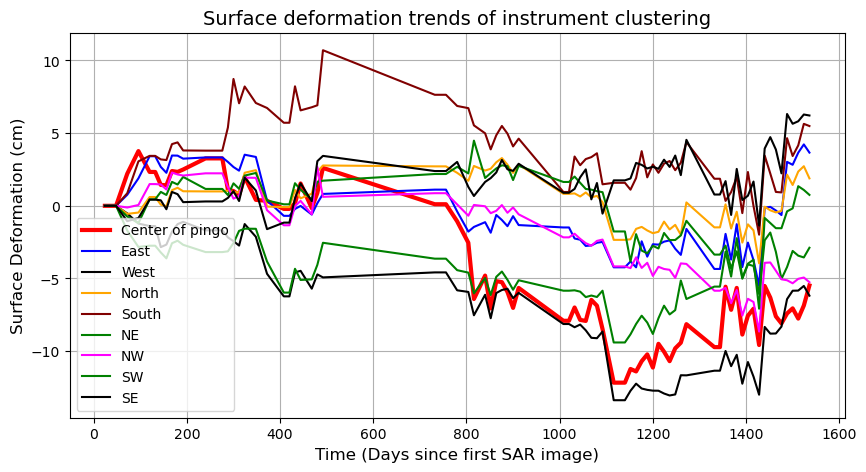

Optimized parameters:
a = 2.953004705452465
b = -0.15712095907676182
Statistical Values:
R^2 = 0.5188813443882851
p value = 1.7511547767412594e-12
RMSE: 0.014550036450747643
Model-derived Cumulative Uplift (cm):  -3.2048541367040717


<Figure size 640x480 with 0 Axes>

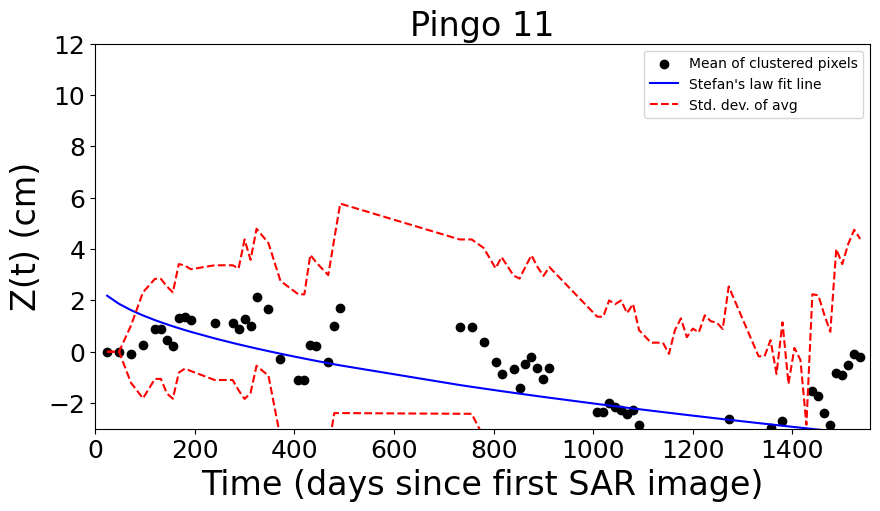

In [432]:
#plotting clustered raw data
cluster(series_good_tot2, 1962, 659)
plt.suptitle('Pingo 11')

#plotting running average and std dev of clustered pix
mean('Pingo 11',series_good_tot2, 1962, 659)

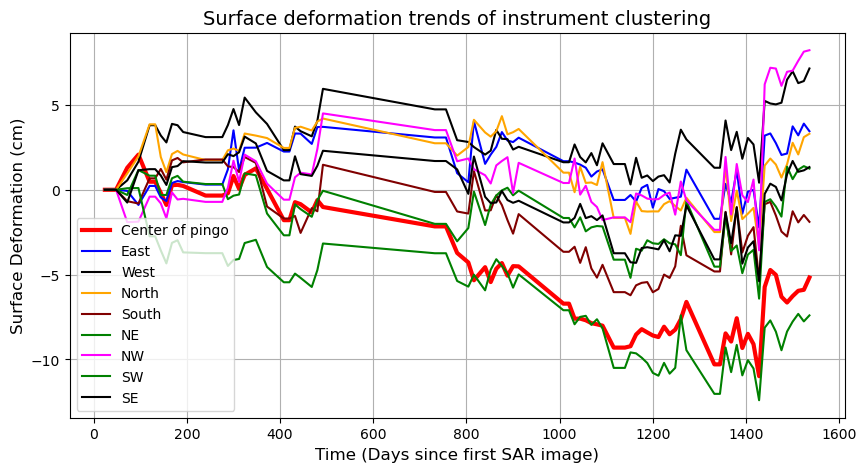

Optimized parameters:
a = 2.1264004297384003
b = -0.11147470796776708
Statistical Values:
R^2 = 0.32509858270090675
p value = 4.807204373458163e-07
RMSE: 0.015446385320355593
Model-derived Cumulative Uplift (cm):  -2.24249803021033


<Figure size 640x480 with 0 Axes>

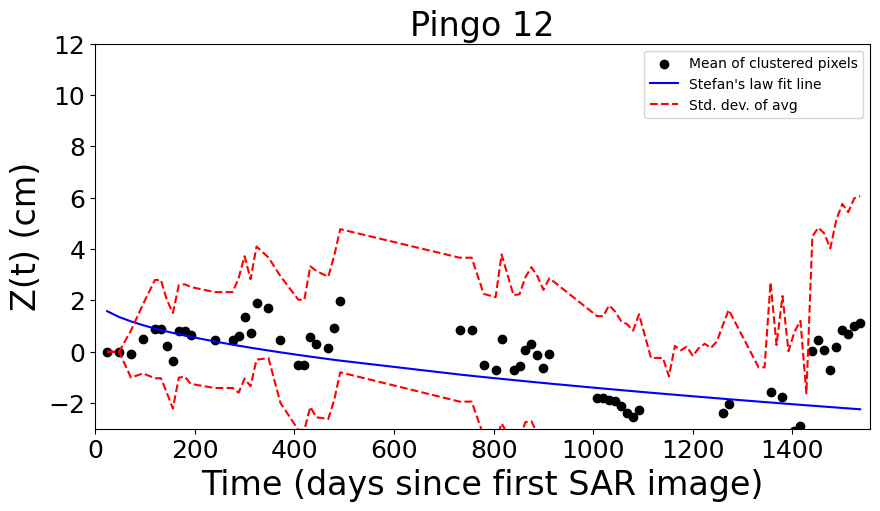

In [433]:
#plotting clustered raw data
cluster(series_good_tot2, 2019, 571)
plt.suptitle('Pingo 12')

#plotting running average and std dev of clustered pix
mean('Pingo 12',series_good_tot2, 2019, 571)

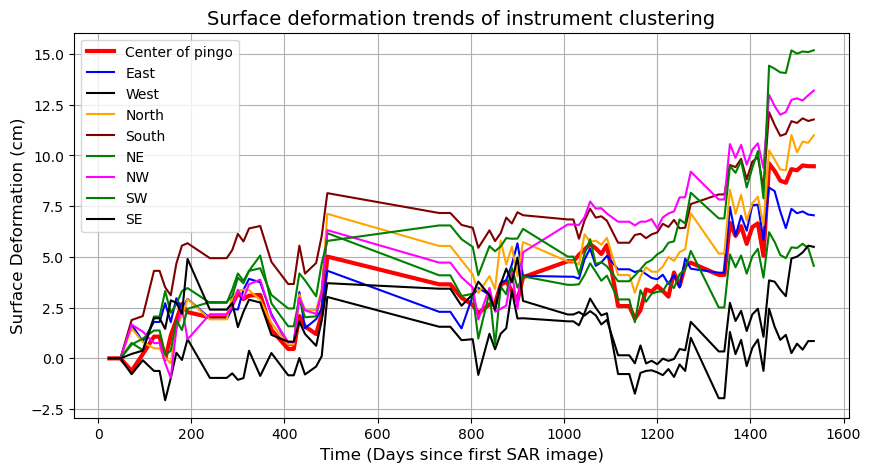

Optimized parameters:
a = -1.0111775585677427
b = 0.18391539163132267
Statistical Values:
R^2 = 0.6514437205651233
p value = 1.1102230246251565e-16
RMSE: 0.01293760749754409
Model-derived Cumulative Uplift (cm):  6.196804286886273


<Figure size 640x480 with 0 Axes>

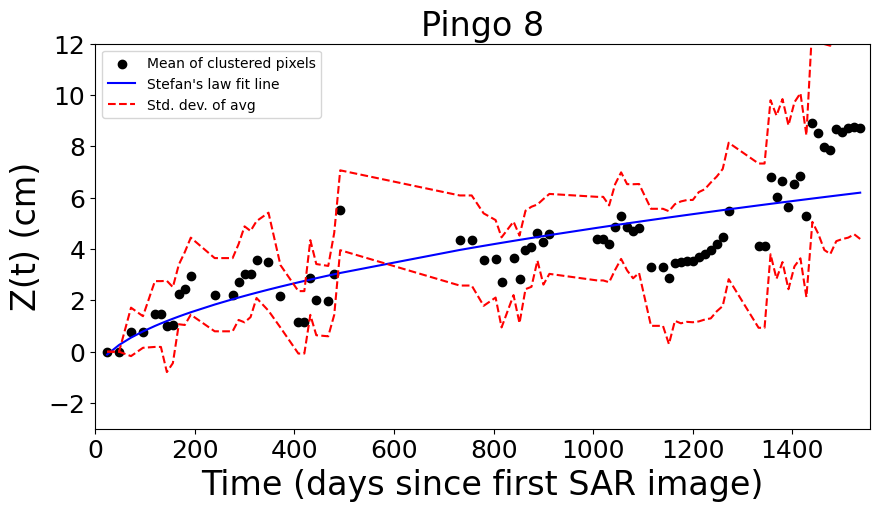

In [434]:
#plotting clustered raw data
cluster(series_good_tot2, 1581, 674)
plt.suptitle('Pingo 8')

#plotting running average and std dev of clustered pix
mean('Pingo 8',series_good_tot2, 1581, 674)

In [435]:
def mean(title,array,y,x):

SyntaxError: incomplete input (1050618236.py, line 1)

In [ ]:

title=''
array=series_good_tot2
y=1581
x=674
#populate list with 9 different arrays
arr = [array[y,x,0:77],array[y+7,x,0:77],array[y-7,x,0:77],array[y,x+7,0:77],array[y,x-7,0:77],array[y+7,x+7,0:77],array[y-7,x+7,0:77],array[y-7,x-7,0:77],array[y+7,x-7,0:77]]
arr = np.array(arr)*100
t_days = np.cumsum(dtime_scenes)
t_days = t_days[0:77]
#convert to numpy array for processing
rolling_avg = np.mean(arr, axis = 0)
std_dev = np.std(arr, axis = 0)

#perform least squares inversion on rolling_avg 
def fractional_polynomial(params, x):
    a, b = params
    return a + b * np.power(x, 0.5)
# Define the residual function
def residual(params, x, y):
    return fractional_polynomial(params, x) - y
# Initial guess for the parameters
initial_params = np.array([1, 1])
# Fit the data using least squares optimization
result = least_squares(residual, initial_params, args=(t_days, rolling_avg))
# Extract the optimized parameters
optimized_params = result.x
# array we want
frac = fractional_polynomial(optimized_params, t_days)
#calculate R^2 value
ss_residual = np.sum((rolling_avg - frac) ** 2)
ss_total = np.sum((rolling_avg - np.mean(rolling_avg)) ** 2)
r_squared = 1 - (ss_residual / ss_total)
#calculate p-value
n = len(rolling_avg)
k = len(optimized_params)
dof = n - k - 1
ssr = ss_residual
mse = ssr / dof
f_value = (ss_total - ss_residual) / k / mse
p_value = 1 - stats.f.cdf(f_value, k, dof)
#calculate RMSE 
rmse = np.sqrt(np.mean((rolling_avg - frac) ** 2))

#print inverted paramters
print("Optimized parameters:")
print("a =", optimized_params[0])
print("b =", optimized_params[1])
#print statistical values
print("Statistical Values:")
print("R^2 =", r_squared)
print("p value =", p_value)
print("RMSE:", rmse/100) 
print("Model-derived Cumulative Uplift (cm): ",frac[-1])
    
fig=plt.figure(figsize = (16,8))
plt.title(title, fontsize = 24)
plt.xlabel('Time (years)', fontsize = 24)
plt.ylabel('Cumulative uplift (cm)', fontsize = 24)
#plt.scatter(t_days, rolling_avg,label='Mean of clustered pixels', color = 'black')
plt.errorbar(t_days, rolling_avg,yerr=std_dev,label='Surface height', color = 'black',fmt='o', capsize=3, capthick=3)
plt.plot(t_days, frac,label='Stefan\'s equation ice accretion model', color = 'blue',ls='-',linewidth=3)
#plt.plot(t_days, rolling_avg - std_dev,label='Std. dev. of avg', color = 'red',ls='--')
#plt.plot(t_days, rolling_avg + std_dev,color = 'red',ls='--')
#y_ticks = ['-8','-6','-4','-2','0','2','4','6','8']
x_days = ['0','200','400','600','800','1000','1200','1400','1600']
#plt.xticks(np.arange(0,1700,200),x_days, fontsize=20)
plt.xticks([60, 425, 790, 1156,1521], ['2017', '2018', '2019', '2020','2021'], fontsize=20)
#plt.yticks(np.arange(-8, 8, 2),y_ticks, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-2,14)
plt.xlim(0, np.max(t_days)+20)
plt.grid(False)
plt.legend(fontsize=24)
plt.show()
fig.savefig('pingo8_time_series.pdf',dpi=400) 